In the 1.4 update, we sought to improve the CNN+LSTM model's performance by implementing a squeeze and stack operation on the input data. This change allows us to present our input data in a way that greatly leverages the LSTM structure: sequentially. As a result, our accuracy increased from 0.745 to 0.769.

In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
#0.1 of 30sec is 3 sec
#try with 0.05 window

def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.1, random_state=42, stratify=arr_genres
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,y_train,random_state=42,test_size=0.1, stratify=y_train)
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)
    X_valid, y_valid = split_convert(X_valid, y_valid)

    return X_train, X_test, y_train, y_test, X_valid, y_valid

In [8]:
# Parameters
gtzan_dir = '../data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test, X_valid, y_valid = read_data(gtzan_dir, genres, song_samples)

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01361084 0.02810669 0.03515625 ... 0.09667969 0.09692383 0.09399414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.43545532 0.4111023  0.39978027 ... 0.02554321 0.01922607 0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09356689  0.09411621  0.09457397 ... -0.09121704 -0.07785034
 -0.08377075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.36462402 0.6788635  0.66937256 ... 0.10751343 0.11825562 0.13479614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02664185 -0.03216553 -0.01217651 ...  0.12194824  0.1232605
  0.13897705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.13635254 0.14697266 0.15402222 ... 0.05880737 0.07391357 0.02966309] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fran

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07641602 0.10653687 0.12106323 ... 0.16583252 0.184906   0.19116211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.4958191  -0.48406982 -0.47735596 ...  0.07714844  0.11465454
  0.1331482 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.22555542  0.24575806  0.2390747  ... -0.18255615 -0.22998047
 -0.21438599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01739502 -0.05499268 -0.13406372 ...  0.06149292  0.03604126
 -0.00613403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.015625    0.05157471 -0.04284668 ...  0.1876831   0.12164307
  0.08041382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 1.7089844e-03  3.0517578e-05 -4.3640137e-03 ...  2.0812988e-02
  4.3853760e-02  1.4041138e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrog

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.27478027 0.34994507 0.39486694 ... 0.49734497 0.39727783 0.41314697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.18945312 0.2532959  0.19400024 ... 0.20361328 0.21826172 0.21591187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.4840088  0.55599976 0.6003418  ... 0.1998291  0.14480591 0.04928589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01553345 -0.00204468  0.0093689  ... -0.02801514 -0.02542114
 -0.02191162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00894165 0.00912476 0.00817871 ... 0.06967163 0.06549072 0.06149292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01898193 -0.01748657 -0.01696777 ...  0.00534058  0.00445557
  0.00314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04656982 -0.04675293 -0.04989624 ...  0.02471924  0.02404785
  0.02133179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00338745 0.00582886 0.00698853 ... 0.01538086 0.01577759 0.01535034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02102661  0.02194214  0.01974487 ... -0.00418091 -0.0015564
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16525269 -0.08828735 -0.01824951 ... -0.16973877 -0.17440796
 -0.15863037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01446533 -0.0246582  -0.02252197 ... -0.00668335  0.00024414
  0.02523804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05038452 -0.0512085  -0.05264282 ... -0.06182861 -0.06445312
 -0.05679321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08972168  0.09130859  0.08096313 ...  0.01535034 -0.00320435
  0.027771  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13711548 -0.23635864 -0.2230835  ... -0.27798462 -0.16973877
 -0.12033081] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07110596 -0.05230713 -0.06585693 ...  0.05776978  0.06896973
  0.1065979 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1126709   0.14300537  0.2109375  ... -0.02160645 -0.01123047
 -0.00222778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00930786  0.01437378  0.01144409 ... -0.02679443 -0.01782227
 -0.00811768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09188843  0.11282349  0.13864136 ...  0.0071106   0.0012207
 -0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00415039 0.00671387 0.00891113 ... 0.02459717 0.02786255 0.03036499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02252197 0.02133179 0.01818848 ... 0.0138855  0.01199341 0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03329468  0.03253174  0.02774048 ... -0.00540161 -0.00289917
  0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00891113 -0.03314209 -0.05255127 ...  0.00115967 -0.00137329
 -0.00714111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03735352 -0.03399658 -0.03659058 ...  0.09268188  0.07537842
  0.06811523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00863647 -0.00765991 -0.02111816 ...  0.00579834  0.00372314
  0.00720215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07437134 -0.0760498  -0.07681274 ... -0.1418457  -0.14154053
 -0.12585449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01702881 -0.01339722 -0.00637817 ... -0.02172852 -0.04043579
 -0.0579834 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09640503 -0.06546021 -0.04537964 ...  0.05239868  0.04364014
  0.04193115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1628418  -0.05236816  0.06066895 ...  0.16345215  0.18106079
  0.16732788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09552002  0.10644531  0.10107422 ...  0.1348877  -0.04473877
 -0.04418945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.21234131 0.27944946 0.31329346 ... 0.0574646  0.06558228 0.06787109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04510498 -0.04742432 -0.04489136 ...  0.08358765  0.09259033
  0.10919189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09283447 -0.07504272 -0.0390625  ...  0.15209961  0.13851929
  0.14395142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.11694336 0.1303711  0.14807129 ... 0.0244751  0.02883911 0.03070068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.206604   -0.12689209 -0.00228882 ...  0.02606201 -0.03536987
 -0.03036499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04122925 -0.06765747 -0.11651611 ... -0.3848877  -0.34594727
 -0.27093506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07354736  0.15145874  0.18963623 ... -0.35028076 -0.30923462
 -0.11489868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03216553 -0.03530884 -0.04284668 ...  0.04382324  0.034729
  0.02835083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1482544  0.13311768 0.12408447 ... 0.07266235 0.06362915 0.03912354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01187134 -0.01968384 -0.03475952 ...  0.02761841  0.07318115
  0.09048462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00430298 -0.00378418  0.00689697 ...  0.06304932  0.09262085
  0.10946655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07080078 -0.07034302 -0.06750488 ...  0.0774231   0.06201172
  0.06054688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.14077759 0.17764282 0.20065308 ... 0.33984375 0.33621216 0.32965088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05450439 -0.00741577  0.03717041 ... -0.32772827 -0.40475464
 -0.47543335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08157349 -0.08218384 -0.09469604 ... -0.52441406 -0.21081543
 -0.10552979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.45581055 -0.4800415  -0.49972534 ... -0.1984253  -0.02682495
  0.10864258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00375366  0.00402832  0.00372314 ... -0.03591919 -0.04214478
 -0.04653931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00640869 -0.00497437 -0.00341797 ... -0.00622559 -0.00753784
 -0.00836182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04980469 -0.05233765 -0.05447388 ... -0.00839233 -0.00891113
 -0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00183105  0.01843262  0.02832031 ... -0.1086731  -0.09536743
 -0.0892334 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02600098  0.03240967  0.03649902 ... -0.00820923 -0.03463745
 -0.03955078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10076904 -0.10427856 -0.11526489 ...  0.02462769  0.02606201
  0.03024292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 6.1035156e-05  1.1138916e-02  2.1484375e-02 ... -4.2813110e-01
 -4.4454956e-01 -4.3286133e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02319336 0.05026245 0.10421753 ... 0.1699524  0.17593384 0.18582153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3955078  -0.3727417  -0.37261963 ...  0.02529907 -0.01806641
 -0.00784302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, 

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16290283 -0.16308594 -0.1864624  ...  0.11917114  0.12347412
  0.09799194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15481567 -0.12554932 -0.27459717 ... -0.08618164 -0.07766724
 -0.146698  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05789185 0.06240845 0.09561157 ... 0.1647644  0.15567017 0.1229248 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09152222  0.07266235  0.05334473 ... -0.1572876  -0.08508301
 -0.04229736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03903198  0.          0.02337646 ...  0.14813232  0.18136597
  0.16973877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00680542  0.0279541  -0.00961304 ...  0.02456665 -0.01089478
 -0.00991821] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03097534 -0.02572632 -0.04800415 ... -0.1267395  -0.12976074
 -0.13168335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01269531  0.0100708   0.00918579 ... -0.06234741 -0.0788269
 -0.08441162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13546753 -0.13824463 -0.13644409 ... -0.26245117 -0.19522095
 -0.13287354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06506348 -0.06375122 -0.08627319 ...  0.00216675 -0.0133667
 -0.06832886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06951904 -0.04144287 -0.02206421 ...  0.12243652 -0.05996704
 -0.05526733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07757568 -0.04681396 -0.04223633 ...  0.04638672  0.08029175
  0.05615234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03387451 -0.04019165 -0.03088379 ... -0.01867676 -0.019104
  0.03405762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02435303 0.02734375 0.05523682 ... 0.04962158 0.08627319 0.13650513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04055786  0.0703125   0.07653809 ... -0.03158569 -0.05728149
 -0.07763672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07653809 -0.07510376 -0.06539917 ...  0.1645813   0.19662476
  0.2020874 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.243927   -0.09646606 -0.04818726 ...  0.2904358   0.26785278
  0.1317749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15847778  0.08850098  0.02734375 ...  0.03985596  0.03005981
 -0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00601196  0.01461792  0.03656006 ... -0.02615356 -0.04379272
 -0.06567383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01556396 -0.01870728 -0.0196228  ... -0.03213501 -0.04208374
 -0.03918457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0710144  -0.07015991 -0.07821655 ... -0.06295776 -0.09326172
 -0.11694336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14727783 -0.1242981  -0.13937378 ... -0.13879395 -0.10043335
 -0.15820312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04403687 -0.02874756 -0.03439331 ...  0.62039185  0.42593384
  0.5371704 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13967896 -0.08422852 -0.13174438 ...  0.18087769  0.21566772
  0.2366333 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02001953 -0.01654053  0.00247192 ...  0.00283813  0.01202393
  0.03253174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.22662354 -0.19277954 -0.1716919  ...  0.22671509  0.21185303
  0.16317749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10604858 -0.08395386 -0.09460449 ... -0.06390381 -0.03225708
 -0.01477051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.2281189  -0.19348145 -0.17242432 ...  0.24380493  0.23617554
  0.13305664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.2519226  -0.4916687  -0.9017334  ... -0.45333862 -0.25717163
 -0.13891602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.17785645  0.36254883  0.27468872 ... -0.07650757 -0.23046875
 -0.17340088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0085144  -0.03482056 -0.02752686 ... -0.12045288 -0.11495972
 -0.10742188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03399658 -0.01016235 -0.01043701 ...  0.1687622   0.1630249
  0.15744019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10119629 -0.09606934 -0.1027832  ... -0.07791138 -0.05883789
 -0.05258179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03161621 -0.0279541  -0.02490234 ...  0.03430176  0.05212402
 -0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.10238647 0.07839966 0.05426025 ... 0.00466919 0.03189087 0.04867554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04693604  0.02047729  0.06652832 ...  0.13311768  0.13409424
  0.15045166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.50717163 -0.4256897  -0.33380127 ... -0.19702148 -0.27178955
 -0.22259521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02301025 0.05325317 0.04727173 ... 0.11532593 0.07763672 0.09579468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10720825 -0.08966064 -0.0914917  ...  0.06924438  0.0774231
  0.06533813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25741577 -0.23858643 -0.16821289 ...  0.068573    0.05163574
  0.04675293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04293823 -0.07843018 -0.08071899 ... -0.04125977  0.03436279
  0.02401733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.06164551 0.07479858 0.06903076 ... 0.11584473 0.12738037 0.14520264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02191162 -0.03604126 -0.03900146 ...  0.00067139 -0.00064087
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00894165 -0.01519775 -0.0163269  ... -0.06951904 -0.05517578
 -0.05233765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00143433 -0.00384521 -0.00418091 ... -0.02371216 -0.02890015
 -0.03338623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07070923 -0.01715088  0.09518433 ... -0.08462524 -0.03256226
 -0.07894897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03149414  0.0227356  -0.0007019  ...  0.0362854   0.07394409
 -0.04724121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02398682  0.11065674  0.14523315 ... -0.05752563 -0.07098389
 -0.05661011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02185059  0.17178345  0.29510498 ...  0.00338745 -0.04125977
 -0.04208374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12179565 -0.12585449 -0.17163086 ...  0.13278198  0.19763184
 -0.03439331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01693726  0.04647827  0.02249146 ... -0.02450562  0.04116821
  0.23300171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21234131 -0.2828369  -0.29275513 ... -0.6039429  -0.59451294
 -0.5388489 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15164185  0.10894775  0.05114746 ...  0.0145874  -0.01654053
 -0.10891724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.4128723  -0.37246704 -0.38098145 ...  0.34805298  0.34249878
  0.29968262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0005188   0.00067139 -0.00146484 ... -0.07684326 -0.07614136
 -0.06686401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01867676 -0.01879883 -0.01739502 ... -0.07034302 -0.05761719
 -0.04150391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05441284 -0.04489136 -0.04003906 ... -0.01068115 -0.01300049
 -0.01745605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00878906 0.01016235 0.04672241 ... 0.5178528  0.53878784 0.5290222 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10995483 -0.20501709 -0.23117065 ...  0.0927124   0.08081055
  0.08792114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.4753418  0.40957642 0.37426758 ... 0.26382446 0.32019043 0.2909546 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04977417 -0.06826782 -0.03289795 ...  0.00561523  0.03778076
  0.03955078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.08694458 0.03430176 0.02008057 ... 0.06546021 0.04180908 0.01971436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03134155  0.0513916   0.04995728 ... -0.12280273 -0.1293335
 -0.11376953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00604248 -0.00961304 -0.0118103  ... -0.01153564 -0.00802612
 -0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00793457 -0.00344849  0.00076294 ...  0.02307129  0.02474976
  0.02374268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00387573 -0.00268555 -0.00231934 ... -0.01712036 -0.01919556
 -0.02053833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01577759  0.03088379  0.03448486 ... -0.07687378 -0.11743164
 -0.1166687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00912476 -0.01531982 -0.02178955 ... -0.15255737 -0.14300537
 -0.13903809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09991455 -0.10217285 -0.11755371 ...  0.08392334  0.06350708
  0.04943848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.24414062  0.2501526   0.2600708  ... -0.20953369 -0.07794189
  0.23526001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.22631836 0.22103882 0.2539978  ... 0.43673706 0.37786865 0.32266235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.43511963  0.44836426  0.400177   ... -0.37243652 -0.768219
 -1.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3359375  -0.45108032 -0.35388184 ... -0.10415649 -0.2846985
 -0.18081665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08383179 -0.2026062  -0.2755127  ...  0.14117432  0.19436646
  0.26843262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13845825 -0.28207397 -0.25024414 ... -0.07363892 -0.00540161
  0.02432251] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05337524 -0.04492188 -0.03866577 ...  0.00668335  0.01422119
  0.01593018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09469604 -0.10473633 -0.09866333 ...  0.03552246  0.02127075
  0.01257324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01870728 0.02484131 0.02111816 ... 0.20727539 0.2010498  0.18707275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09188843 -0.10174561 -0.13830566 ...  0.15011597  0.03439331
 -0.07202148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14639282 -0.22491455 -0.21121216 ... -0.14715576 -0.09906006
  0.05636597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25109863 -0.14990234 -0.04144287 ... -0.24905396 -0.184021
 -0.10324097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07785034 0.13467407 0.09841919 ... 0.01193237 0.03921509 0.05200195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07049561 -0.06063843 -0.04129028 ...  0.29943848  0.35516357
  0.41226196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.19439697 0.16574097 0.10437012 ... 0.11901855 0.09313965 0.12554932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00073242 -0.00027466 -0.00231934 ... -0.01187134 -0.01287842
 -0.01205444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01119995  0.00848389  0.00723267 ... -0.01907349 -0.02346802
 -0.02774048] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01016235 -0.0071106  -0.00369263 ... -0.01574707 -0.01153564
 -0.00561523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03778076  0.15744019  0.32974243 ... -0.02023315  0.00588989
  0.02532959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.27230835 0.27859497 0.36380005 ... 0.3902588  0.3959961  0.3907776 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02651978 -0.02719116 -0.02828979 ... -0.53778076 -0.36843872
 -0.3421631 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05117798  0.18710327 -0.13528442 ...  0.32687378  0.31695557
  0.28842163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01525879 -0.03271484 -0.02252197 ...  0.13394165 -0.17129517
 -0.13226318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.15011597 0.28164673 0.26934814 ... 0.13485718 0.22174072 0.21987915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.17910767 -0.16625977 -0.1546936  ...  0.015625    0.0289917
  0.04067993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21673584 -0.26705933 -0.1864624  ... -0.21087646 -0.21173096
 -0.20773315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05197144  0.0632019   0.07073975 ... -0.08795166 -0.08517456
 -0.07476807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00341797 -0.00448608 -0.00436401 ...  0.01531982  0.01715088
  0.01870728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05960083 -0.05593872 -0.0524292  ...  0.02398682  0.02285767
  0.02163696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02008057  0.02145386  0.02264404 ...  0.23727417  0.0098877
 -0.16186523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04403687 0.05740356 0.05758667 ... 0.18133545 0.17181396 0.20513916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06011963  0.07519531  0.07647705 ... -0.22741699 -0.16989136
 -0.10946655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.2607727   0.33007812  0.32315063 ... -0.36575317 -0.43136597
 -0.4590149 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12033081 -0.18588257 -0.12045288 ...  0.63534546  0.6718445
  0.53619385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1845398   0.21749878  0.27111816 ... -0.4031067  -0.09677124
 -0.05862427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.58078    0.59210205 0.63378906 ... 0.30630493 0.3718872  0.30136108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08865356 -0.1031189  -0.11953735 ... -0.01434326 -0.01455688
 -0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00415039 -0.00360107 -0.00231934 ... -0.01113892 -0.01348877
 -0.01596069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01712036 -0.02050781 -0.02209473 ...  0.00366211  0.00366211
  0.00366211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.02206421 -0.0072937
 -0.0213623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00158691 -0.0015564  -0.00143433 ... -0.9165039  -0.927948
 -0.95443726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01071167 -0.02227783 -0.0696106  ... -0.04000854 -0.02600098
  0.01556396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09057617 0.06509399 0.05130005 ... 0.00704956 0.0211792  0.02044678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06414795 -0.10864258 -0.10760498 ...  0.05938721  0.05752563
  0.0508728 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15872192 -0.19326782 -0.22106934 ...  0.10842896  0.09970093
  0.1144104 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00402832 -0.00210571 -0.00534058 ... -0.02371216 -0.01528931
 -0.00842285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01876831 -0.01153564 -0.0067749  ...  0.00131226 -0.00631714
 -0.01324463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00216675  0.00375366  0.00521851 ... -0.02203369 -0.01473999
 -0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05285645  0.05178833  0.04888916 ... -0.01452637 -0.01205444
 -0.01019287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.11831665 0.11764526 0.11746216 ... 0.02243042 0.02346802 0.02282715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00549316  0.00057983  0.00106812 ...  0.03533936  0.0289917
  0.02520752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01177979 -0.02996826  0.04333496 ... -0.00344849  0.00823975
  0.01483154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.305542   -0.2635498  -0.287323   ... -0.00717163 -0.02017212
 -0.02093506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03060913 0.02371216 0.01782227 ... 0.09997559 0.07266235 0.1121521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01168823 -0.11682129 -0.04089355 ... -0.01800537 -0.03347778
 -0.04440308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1088562  -0.16165161 -0.15151978 ... -0.17901611 -0.16848755
 -0.15487671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0763855  -0.09896851 -0.08197021 ... -0.04031372 -0.09423828
 -0.12625122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14190674 -0.16479492 -0.11679077 ...  0.01928711  0.00598145
  0.00570679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21133423  0.20993042  0.22061157 ... -0.04367065 -0.03955078
 -0.0479126 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01660156 0.0383606  0.05715942 ... 0.10031128 0.09521484 0.07388306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00665283 -0.00610352 -0.00759888 ...  0.1512146   0.1401062
  0.07800293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01635742 -0.0133667  -0.01367188 ...  0.00982666  0.01235962
  0.00973511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0289917   0.03283691  0.00311279 ... -0.03488159 -0.02755737
 -0.09616089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06759644 -0.07315063 -0.00598145 ... -0.01800537 -0.06646729
 -0.11828613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.4194641   0.33566284  0.25961304 ... -0.37060547 -0.50509644
 -0.5232849 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00671387 -0.01416016 -0.19796753 ... -0.25012207 -0.30667114
 -0.19766235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04202271  0.0480957   0.03155518 ... -0.00689697 -0.01638794
 -0.01211548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0798645   0.08981323  0.08569336 ...  0.0043335   0.00360107
 -0.0032959 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00231934 -0.00057983 -0.01028442 ...  0.05401611  0.06890869
  0.07626343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08746338 -0.08865356 -0.09692383 ... -0.14822388 -0.13311768
 -0.1194458 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04135132  0.01611328  0.03564453 ... -0.03665161 -0.00363159
  0.02163696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10229492 -0.09515381 -0.0874939  ... -0.07931519 -0.03851318
 -0.00909424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1777649  0.1595459  0.16207886 ... 0.23428345 0.20318604 0.1545105 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09814453 0.07565308 0.05212402 ... 0.0383606  0.03497314 0.02056885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0854187  -0.0062561  -0.09957886 ...  0.01425171  0.01821899
  0.01669312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16363525  0.06906128  0.06646729 ... -0.0296936   0.01422119
  0.043396  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11743164  0.09112549 -0.07479858 ...  0.05883789 -0.0836792
  0.1871643 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11520386  0.11380005  0.24450684 ... -0.01461792 -0.01745605
 -0.02325439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05029297  0.05880737  0.0741272  ...  0.02862549  0.00723267
 -0.01901245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14724731  0.17489624  0.23635864 ... -0.08065796 -0.11376953
 -0.19329834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01324463  0.02832031  0.07659912 ... -0.01626587 -0.02267456
 -0.02008057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.36224365 -0.311615   -0.17953491 ...  0.00515747  0.08642578
  0.03872681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00576782 -0.01199341 -0.05456543 ... -0.0930481   0.03729248
  0.06350708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04571533 -0.07907104  0.03289795 ...  0.24334717  0.23504639
  0.18243408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10818481  0.3574829   0.36968994 ... -0.03491211 -0.0546875
 -0.04986572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04135132  0.04644775  0.04544067 ...  0.08401489  0.04431152
 -0.01757812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02444458  0.00820923  0.03106689 ...  0.03048706  0.07641602
  0.09024048] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02737427  0.03411865  0.05444336 ... -0.01068115 -0.00460815
 -0.00549316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01882935 0.07373047 0.09246826 ... 0.13369751 0.10751343 0.12313843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.009552   -0.01171875 -0.00827026 ... -0.11273193 -0.12316895
 -0.11349487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.43481445 0.386261   0.2975769  ... 0.20443726 0.14968872 0.11282349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05645752 -0.13531494 -0.01437378 ... -0.00482178 -0.01226807
 -0.00674438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14605713  0.17849731  0.18981934 ... -0.10827637 -0.09286499
 -0.13809204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.34561157 0.32614136 0.2977295  ... 0.12417603 0.12347412 0.19558716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12234497 -0.18878174 -0.10623169 ...  0.08532715  0.1481018
  0.05966187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.20788574  0.1819458   0.17434692 ... -0.04187012 -0.11126709
  0.01333618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01419067 -0.01144409 -0.0177002  ... -0.0213623  -0.040802
 -0.03512573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0249939  0.03469849 0.06323242 ... 0.0723877  0.08218384 0.09161377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03051758 -0.02429199 -0.03833008 ...  0.00238037  0.00723267
  0.00491333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00015259 -0.00125122 -0.00137329 ...  0.03634644  0.03482056
  0.02923584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0322876  -0.03045654 -0.01522827 ...  0.03060913  0.03292847
  0.03344727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05004883 -0.04971313  0.04592896 ...  0.18682861  0.09320068
 -0.03884888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06533813  0.05166626  0.07116699 ... -0.14126587 -0.10140991
 -0.03115845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00698853 -0.02755737  0.03939819 ...  0.20581055  0.10360718
 -0.03915405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01644897 -0.12210083 -0.16067505 ...  0.04858398 -0.00891113
 -0.11434937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3947754  -0.2982788  -0.31192017 ...  0.05599976 -0.00106812
 -0.02618408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08358765 -0.12136841 -0.1354065  ...  0.07427979  0.22814941
  0.09185791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05267334  0.11584473 -0.04833984 ... -0.00939941 -0.01000977
 -0.01864624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09753418 -0.13638306 -0.07846069 ...  0.03939819  0.00134277
 -0.04147339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02380371  0.00238037  0.00552368 ... -0.00241089 -0.00909424
 -0.02688599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02011108 -0.00793457 -0.02593994 ... -0.00595093 -0.07357788
 -0.1661377 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09692383 -0.01351929  0.03503418 ...  0.14285278  0.08969116
 -0.02844238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02981567 -0.02212524 -0.00064087 ... -0.03335571 -0.02749634
 -0.03088379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02337646  0.01895142  0.04492188 ... -0.07687378 -0.04138184
  0.01412964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00872803 -0.00985718 -0.01672363 ...  0.00946045  0.00592041
  0.00796509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0329895  -0.02770996 -0.02642822 ...  0.02468872  0.01370239
  0.03320312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01013184 0.01086426 0.02008057 ... 0.00518799 0.00183105 0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16107178 -0.17819214 -0.21762085 ...  0.5357666   0.5595093
  0.4711609 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.18811035 0.11920166 0.04403687 ... 0.18338013 0.22488403 0.21838379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21081543  0.1086731   0.1798706  ... -0.02630615 -0.2755432
 -0.36160278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0015564  0.03994751 0.07223511 ... 0.01202393 0.01150513 0.01251221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.23916626 -0.24716187 -0.25619507 ...  0.00527954  0.00643921
  0.00814819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01290894  0.01147461  0.01028442 ... -0.01928711 -0.01309204
 -0.00747681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10534668 -0.05340576 -0.03756714 ... -0.03451538 -0.02627563
 -0.02203369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.20846558 -0.18630981 -0.1593628  ... -0.04327393 -0.04284668
 -0.03686523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02249146 -0.02731323 -0.02618408 ... -0.1100769  -0.11947632
 -0.11993408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10165405 -0.09896851  0.06610107 ... -0.22836304 -0.39486694
 -0.5370178 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.45516968 0.26895142 0.12368774 ... 0.20117188 0.243927   0.2015686 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.5344238  -0.37817383 -0.2906189  ...  0.58776855  0.6534424
  0.5872803 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12716675 -0.07028198 -0.00735474 ... -0.01934814 -0.01065063
 -0.01748657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06484985 -0.08065796 -0.08172607 ...  0.00344849 -0.01300049
 -0.02767944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02938843 -0.02935791 -0.01965332 ...  0.13858032  0.11691284
  0.10339355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04153442 -0.03097534 -0.02120972 ... -0.07040405 -0.07751465
 -0.08929443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00878906 -0.00320435  0.00393677 ...  0.01373291  0.01641846
  0.02096558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08822632 -0.08828735 -0.08874512 ... -0.0887146  -0.08483887
 -0.08084106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01483154  0.01028442  0.04827881 ...  0.03765869  0.07278442
  0.05477905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.20178223  0.2480774   0.2878723  ... -0.04840088 -0.04785156
  0.00448608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05892944 0.06942749 0.05487061 ... 0.05511475 0.05117798 0.03192139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08325195 -0.08154297 -0.09640503 ...  0.05053711  0.06903076
  0.05307007] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07070923 -0.01885986  0.02563477 ...  0.07327271  0.12472534
  0.21932983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04754639  0.02905273  0.01248169 ... -0.03018188  0.00265503
  0.01062012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25582886 -0.2824707  -0.30169678 ... -0.02218628 -0.01095581
  0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.41638184 -0.43945312 -0.45159912 ...  0.25656128  0.26242065
  0.28842163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00924683 -0.01412964 -0.02642822 ... -0.0982666  -0.1453247
 -0.1296997 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10717773 -0.05612183 -0.00698853 ... -0.01495361 -0.00628662
  0.00656128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00552368 -0.01431274 -0.03039551 ... -0.07653809 -0.07046509
 -0.06640625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01403809  0.02172852  0.03198242 ... -0.00317383 -0.00582886
 -0.01394653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04953003 -0.07839966 -0.1348877  ... -0.04455566 -0.05368042
  0.02462769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07409668  0.01577759  0.01254272 ...  0.01281738 -0.03283691
 -0.03717041] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10925293  0.1274414   0.0229187  ... -0.12524414 -0.1428833
 -0.17160034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06478882  0.06454468  0.00170898 ... -0.05429077  0.00250244
  0.0463562 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.23339844 0.14486694 0.12338257 ... 0.21057129 0.26010132 0.23373413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02410889 -0.00033569 -0.02337646 ... -0.02282715 -0.06265259
 -0.0100708 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.11727905 0.08126831 0.08398438 ... 0.3388672  0.30303955 0.26934814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00473022 -0.00387573 -0.0038147  ... -0.01153564 -0.01147461
 -0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.23516846 0.20739746 0.20535278 ... 0.16503906 0.22918701 0.30471802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.06826782 0.06576538 0.06201172 ... 0.13101196 0.13882446 0.13180542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07775879 0.07015991 0.06808472 ... 0.07043457 0.07019043 0.07409668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.13696289 0.1532898  0.16320801 ... 0.02981567 0.02880859 0.02645874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02200317  0.02191162  0.02258301 ... -0.01153564 -0.0093689
 -0.00881958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01791382 -0.01620483 -0.01837158 ... -0.00778198 -0.0088501
 -0.00900269] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00616455 -0.00421143 -0.00549316 ... -0.03652954 -0.03326416
 -0.03173828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.14160156 0.16256714 0.19381714 ... 0.06201172 0.12142944 0.13757324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12640381  0.15274048  0.14987183 ...  0.03286743 -0.0456543
 -0.09667969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12960815  0.08834839  0.08425903 ... -0.07562256 -0.1388855
 -0.12619019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04910278 -0.11016846 -0.1532898  ...  0.10824585  0.12411499
  0.09115601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06396484  0.06243896  0.03494263 ... -0.00646973 -0.01278687
 -0.03616333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05056763 0.0453186  0.0173645  ... 0.04724121 0.09030151 0.11044312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09173584 -0.0980835  -0.16897583 ...  0.00714111  0.00756836
  0.00732422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.33847046 -0.3227539  -0.31100464 ...  0.08105469 -0.00796509
 -0.03369141] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00640869  0.00369263 -0.00134277 ... -0.07699585 -0.0894165
 -0.09918213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05136108 -0.08282471 -0.08230591 ...  0.26483154  0.23272705
  0.22158813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13534546 -0.06710815 -0.03149414 ...  0.06417847  0.06240845
 -0.00201416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.22268677  0.2206726   0.26132202 ... -0.02993774 -0.0362854
 -0.04495239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.17068481 0.13116455 0.12686157 ... 0.04098511 0.03866577 0.02880859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00604248 -0.01721191 -0.01159668 ... -0.14501953 -0.16357422
 -0.19015503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02383423  0.04129028  0.05447388 ... -0.06222534 -0.06521606
 -0.07443237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11288452 -0.10220337 -0.11340332 ... -0.37820435 -0.43743896
 -0.43847656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0949707  -0.01968384  0.00802612 ...  0.01074219  0.00305176
 -0.00350952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.39904785 -0.35803223 -0.32418823 ...  0.04638672  0.05432129
  0.06002808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00244141 -0.00534058 -0.01660156 ...  0.07296753  0.04608154
 -0.006073  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.22332764 -0.19812012 -0.17376709 ...  0.02294922  0.01480103
  0.01245117] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04492188 -0.07070923 -0.08834839 ... -0.03240967 -0.03924561
 -0.05184937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04269409 0.09317017 0.10488892 ... 0.16156006 0.18060303 0.19882202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05725098 0.07333374 0.09542847 ... 0.44140625 0.49954224 0.31970215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21887207  0.23947144  0.2381897  ... -0.1836853  -0.03555298
 -0.15234375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07510376  0.11038208  0.12979126 ... -0.00436401 -0.03469849
 -0.06045532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3394165  -0.31521606 -0.32211304 ... -0.05966187 -0.03744507
 -0.00750732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09390259 -0.1244812  -0.13946533 ...  0.14016724  0.12966919
  0.06335449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.19107056  0.16720581  0.12924194 ... -0.22650146 -0.19613647
 -0.16238403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.19763184 -0.26470947 -0.3000183  ... -0.11968994 -0.15518188
 -0.17697144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15454102 -0.20385742 -0.24917603 ...  0.32177734  0.27053833
  0.20578003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01187134 -0.01251221 -0.01293945 ... -0.00317383 -0.00476074
 -0.00643921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00515747 0.00405884 0.0032959  ... 0.02612305 0.03128052 0.04095459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00772095 -0.00830078 -0.00830078 ...  0.10055542  0.10848999
  0.10321045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25234985 -0.24438477 -0.25152588 ... -0.07983398 -0.0524292
 -0.0531311 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.19351196 -0.20083618 -0.16479492 ... -0.20455933 -0.23260498
 -0.25073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05187988 -0.04187012 -0.00387573 ... -0.04525757 -0.01586914
  0.03408813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04095459  0.07424927  0.0859375  ...  0.04135132  0.0819397
  0.11437988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02258301 -0.00439453  0.00469971 ...  0.06765747  0.1232605
  0.13549805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08392334  0.00708008 -0.01278687 ...  0.23846436  0.19522095
  0.16415405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0239563  0.05221558 0.06613159 ... 0.21582031 0.21347046 0.19802856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14816284  0.1144104   0.16629028 ... -0.03619385 -0.02758789
 -0.05740356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.2319336  0.2645874  0.2203064  ... 0.04879761 0.13232422 0.22427368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.33999634  0.37368774  0.3416443  ... -0.09130859 -0.15942383
 -0.12854004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0295105  -0.02590942 -0.02764893 ...  0.14529419  0.08612061
 -0.00958252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13476562 -0.14920044 -0.10415649 ...  0.06219482  0.19400024
  0.21343994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04373169  0.05047607  0.04940796 ... -0.02194214 -0.02459717
 -0.02560425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0307312  -0.03219604 -0.02667236 ...  0.02072144  0.0227356
  0.027771  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02575684 -0.02813721 -0.02886963 ... -0.02752686 -0.03979492
 -0.04721069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1111145  -0.09866333 -0.04815674 ...  0.03533936  0.03146362
  0.02593994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03308105 -0.01083374 -0.02630615 ... -0.08895874 -0.10488892
 -0.09725952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03775024  0.04458618  0.04003906 ... -0.02871704 -0.02536011
 -0.01431274] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03591919 -0.03796387 -0.03588867 ...  0.05227661  0.00756836
 -0.00643921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00354004  0.03012085  0.06262207 ... -0.05633545 -0.05380249
 -0.05200195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01409912  0.0244751   0.00338745 ...  0.04354858  0.03933716
  0.03033447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01370239 0.12802124 0.35668945 ... 0.25375366 0.222229   0.0305481 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08892822  0.05697632  0.01843262 ... -0.10916138  0.17401123
  0.06689453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00152588 -0.03793335 -0.06546021 ... -0.29629517 -0.2479248
 -0.14019775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09286499 -0.11831665 -0.12179565 ...  0.02981567  0.025177
  0.00549316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05078125  0.01681519  0.04043579 ... -0.13711548 -0.13269043
 -0.12521362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01605225  0.04052734  0.02957153 ... -0.02404785 -0.03735352
 -0.03219604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00872803  0.04907227  0.08917236 ... -0.00213623 -0.01498413
 -0.02056885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01809692 0.01565552 0.01483154 ... 0.00085449 0.0045166  0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01303101 -0.00128174 -0.00268555 ... -0.00643921  0.00549316
  0.01641846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07794189  0.0218811   0.01638794 ... -0.24240112 -0.09536743
  0.11495972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10321045 -0.00576782  0.07333374 ...  0.18460083  0.16308594
 -0.0038147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10482788 -0.03659058 -0.20727539 ...  0.10446167 -0.02633667
 -0.18725586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08856201  0.11849976  0.11065674 ... -0.13812256 -0.1630249
 -0.2258606 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0177002  0.0458374  0.07736206 ... 0.04104614 0.04324341 0.04760742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.32473755 -0.27334595 -0.20220947 ...  0.13128662  0.06787109
  0.07781982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08450317 -0.08328247 -0.08468628 ... -0.17514038 -0.20391846
 -0.17471313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02429199  0.03240967  0.07989502 ... -0.06893921 -0.03634644
 -0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.19238281 -0.2083435  -0.20010376 ...  0.08035278  0.07888794
  0.07888794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05737305  0.08178711  0.08175659 ...  0.00610352  0.1774292
 -0.15777588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03094482  0.32177734  0.322052   ...  0.11288452  0.06240845
  0.08599854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.236969   -0.24719238 -0.15887451 ...  0.12350464  0.11560059
  0.0541687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0255127   0.14050293  0.283844   ... -0.285614   -0.09521484
 -0.04257202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07635498 -0.0619812  -0.03930664 ...  0.24356079  0.20632935
  0.21774292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15219116 -0.28289795 -0.24447632 ... -0.2295227  -0.23208618
 -0.23623657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01071167 -0.01080322 -0.01281738 ...  0.08093262  0.11602783
  0.10757446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.2621765   0.19979858  0.19152832 ... -0.04629517  0.02780151
 -0.05065918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05596924  0.050354    0.09655762 ... -0.11355591 -0.10128784
 -0.08029175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.08300781 0.08029175 0.07485962 ... 0.20306396 0.22061157 0.20513916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00427246  0.13143921 -0.02932739 ... -0.13613892  0.01248169
 -0.11456299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21469116  0.22994995  0.25082397 ... -0.034729   -0.03445435
 -0.04592896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0177002   0.10534668  0.09173584 ... -0.04342651 -0.16079712
 -0.15560913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10708618  0.00515747  0.13302612 ...  0.24612427  0.28756714
  0.3161621 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08520508 -0.22058105 -0.35202026 ...  0.29800415  0.28479004
  0.16400146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00323486 -0.00567627 -0.00866699 ...  0.00128174 -0.00201416
  0.00927734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03604126 0.02603149 0.02212524 ... 0.04562378 0.03543091 0.02618408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03674316  0.07550049  0.09146118 ... -0.01638794 -0.00915527
  0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.39733887  0.69589233  0.26986694 ... -0.04367065 -0.0395813
 -0.02575684] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09957886 -0.02316284  0.02215576 ... -0.03692627  0.01089478
  0.09350586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02426147 -0.03393555 -0.01144409 ...  0.15148926  0.13446045
  0.02340698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04431152 -0.06570435 -0.08145142 ...  0.01287842 -0.00924683
 -0.01605225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.18869019 0.14828491 0.20462036 ... 0.17300415 0.14581299 0.12042236] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00524902 -0.00283813  0.04214478 ...  0.03616333  0.00048828
  0.00564575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01806641 -0.03585815 -0.11965942 ...  0.06698608  0.06521606
  0.11187744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25634766 -0.34231567 -0.38809204 ... -0.04598999 -0.06860352
 -0.07046509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06756592 -0.18374634 -0.11587524 ... -0.04095459 -0.02578735
 -0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00119019 -0.00796509 -0.01553345 ...  0.06719971  0.06243896
  0.05661011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05914307  0.03833008  0.01629639 ... -0.0597229  -0.06234741
 -0.06393433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04794312  0.03851318  0.03060913 ... -0.01605225 -0.01751709
 -0.01971436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.17565918 -0.22183228 -0.215271   ... -0.1494751  -0.15136719
 -0.12976074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03384399 -0.04119873 -0.04055786 ... -0.09579468 -0.06451416
 -0.12039185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09689331 -0.07006836 -0.05325317 ... -0.13116455 -0.11187744
 -0.08969116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 3.2443237e-01  4.2480469e-02  1.3980103e-01 ...  1.8798828e-02
  2.1362305e-04 -1.6662598e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.23464966 -0.24285889 -0.23693848 ... -0.05075073 -0.05770874
 -0.07827759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01998901  0.00296021  0.00521851 ... -0.45806885 -0.4420166
 -0.4336853 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogr

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00057983  0.01248169  0.00747681 ... -0.0491333  -0.03872681
 -0.04342651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16738892 -0.15975952 -0.13894653 ... -0.24234009 -0.18969727
 -0.03945923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03579712 -0.0194397  -0.0112915  ... -0.06808472 -0.07067871
 -0.15545654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16812134  0.1408081   0.14764404 ... -0.07543945 -0.0128479
  0.06167603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15789795  0.30950928  0.26065063 ...  0.03668213 -0.01535034
 -0.14328003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14715576  0.06533813 -0.02154541 ...  0.05148315  0.02075195
  0.08889771] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1701355  -0.14376831 -0.13256836 ... -0.03585815 -0.025177
 -0.04904175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02868652 -0.01300049 -0.01672363 ... -0.07788086 -0.05859375
 -0.07266235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0501709  -0.07125854 -0.09155273 ... -0.21276855 -0.07382202
 -0.10925293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02044678  0.03042603  0.05053711 ...  0.02600098  0.03250122
  0.1194458 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1116333  -0.12918091 -0.03915405 ...  0.11380005  0.13092041
  0.15762329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01608276 -0.03717041  0.06713867 ... -0.21438599 -0.01486206
  0.13955688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06048584  0.02685547  0.00109863 ... -0.12042236 -0.07339478
 -0.04815674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00860596 -0.04452515 -0.04620361 ... -0.11578369 -0.07373047
  0.02740479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02072144  0.0022583  -0.00012207 ...  0.05200195  0.10446167
  0.04864502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09396362 0.06732178 0.13015747 ... 0.04077148 0.04632568 0.04949951] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03378296 -0.03445435 -0.03399658 ...  0.0206604   0.02487183
  0.02749634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05371094  0.0574646   0.05999756 ... -0.04168701 -0.03363037
 -0.02203369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01971436 -0.01867676 -0.01708984 ...  0.02011108  0.02084351
  0.02148438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07629395  0.0406189   0.00839233 ... -0.03573608 -0.06622314
 -0.08010864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02120972 0.02148438 0.02200317 ... 0.06460571 0.06060791 0.05697632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05072021 -0.02709961 -0.07885742 ...  0.00799561  0.02526855
  0.03500366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00708008 -0.00509644 -0.00595093 ... -0.009552   -0.03219604
 -0.07629395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01730347  0.00787354  0.02679443 ... -0.14526367 -0.18969727
 -0.1131897 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00784302 -0.0123291  -0.01324463 ... -0.0184021  -0.01272583
 -0.01525879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0887146   0.08908081  0.09475708 ... -0.03134155 -0.03540039
 -0.04000854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00665283 -0.00039673  0.00976562 ... -0.04058838 -0.04620361
 -0.0475769 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.27770996 -0.38571167 -0.23297119 ... -0.5393982  -0.3784485
 -0.36010742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12802124  0.01187134 -0.06643677 ... -0.27105713 -0.30114746
 -0.3435669 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.46228027 -0.33410645 -0.26867676 ...  0.02017212  0.05889893
  0.1737976 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06518555  0.10369873  0.07818604 ... -0.09481812 -0.09881592
 -0.12307739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.2088623  -0.19708252 -0.16262817 ... -0.00900269  0.00894165
 -0.00393677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07669067 -0.01986694  0.05551147 ... -0.3682251  -0.33514404
 -0.34487915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21289062  0.22323608  0.22695923 ... -0.10394287 -0.10668945
 -0.10742188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09378052 0.0954895  0.10342407 ... 0.09561157 0.09210205 0.0769043 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11935425 -0.12670898 -0.13961792 ...  0.7658081   0.6025696
  0.6190796 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03588867 -0.05154419 -0.06304932 ... -0.05648804 -0.0809021
 -0.05770874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04504395 -0.03155518 -0.02127075 ...  0.02639771  0.01547241
  0.01000977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06030273 -0.10043335 -0.09109497 ...  0.00183105 -0.00140381
 -0.00949097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.5189514  0.51104736 0.53759766 ... 0.04428101 0.04769897 0.02590942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05395508 0.07388306 0.11047363 ... 0.01028442 0.00958252 0.00827026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.019104   -0.03884888 -0.0189209  ... -0.0022583   0.00378418
  0.00228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10479736 -0.09695435 -0.0897522  ...  0.03634644  0.02529907
  0.01623535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15301514 -0.17422485 -0.18338013 ... -0.00320435 -0.01074219
 -0.02160645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07040405 -0.02722168  0.03128052 ... -0.07058716 -0.07681274
 -0.07278442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00598145  0.00421143  0.00238037 ... -0.01516724 -0.0199585
 -0.02539062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00112915 -0.00448608 -0.00891113 ... -0.03738403 -0.04421997
 -0.04803467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08343506  0.11889648  0.06570435 ... -0.17767334 -0.10726929
 -0.04232788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00982666 0.04577637 0.06484985 ... 0.07196045 0.04598999 0.01348877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3456726   0.33068848  0.2987976  ...  0.02215576 -0.06039429
 -0.09362793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00085449  0.01055908  0.05221558 ... -0.04418945 -0.06280518
 -0.0585022 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06787109 -0.06417847 -0.05599976 ... -0.01858521 -0.01339722
 -0.00680542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00906372 -0.00527954  0.00180054 ... -0.09188843 -0.09127808
 -0.09011841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00018311  0.00601196  0.01168823 ...  0.08074951  0.06680298
  0.05230713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04608154  0.07775879  0.12573242 ...  0.08456421  0.15911865
 -0.03604126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.2293396  0.34823608 0.48129272 ... 0.3421631  0.38137817 0.31149292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04309082  0.00143433 -0.02267456 ... -0.13198853 -0.09536743
 -0.0854187 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.38967896  0.37261963  0.36376953 ...  0.08004761 -0.08609009
  0.03341675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05947876 -0.17962646 -0.18045044 ...  0.02386475  0.07028198
  0.05776978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00817871  0.00778198  0.0067749  ... -0.10467529 -0.11123657
 -0.11062622] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09088135 -0.10708618 -0.07373047 ...  0.03189087  0.0022583
  0.08895874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11727905  0.00820923  0.07739258 ... -0.08456421 -0.12060547
 -0.06277466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05508423  0.08148193  0.04244995 ... -0.05343628 -0.12918091
 -0.15905762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14624023 -0.02487183 -0.0602417  ...  0.00405884 -0.00079346
  0.08319092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10696411  0.12329102  0.04718018 ... -0.19863892 -0.01065063
  0.04937744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05834961  0.07666016  0.11001587 ...  0.06442261 -0.10025024
 -0.18380737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00332642  0.00976562  0.03512573 ... -0.00418091  0.00741577
  0.00610352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04071045 -0.06918335 -0.12667847 ...  0.01199341  0.08187866
  0.09121704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 2.74658203e-04 -4.57763672e-03 -1.26953125e-02 ... -2.12890625e-01
 -2.52655029e-01 -3.03955078e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melsp

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02749634  0.04165649  0.00466919 ...  0.00506592  0.00506592
  0.00823975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08074951  0.28250122  0.350708   ... -0.08352661  0.09454346
 -0.05578613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01077271  0.01293945  0.012146   ... -0.18481445 -0.16815186
 -0.12426758] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.9994812  -1.         -1.         ...  0.5243225   0.43234253
  0.46987915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04528809 -0.01507568 -0.07400513 ...  0.02825928  0.02755737
  0.03268433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.56274414  0.55163574  0.44451904 ... -0.24331665 -0.22473145
 -0.24353027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00961304 -0.01715088 -0.0295105  ...  0.00384521  0.01159668
  0.04351807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03027344 -0.03341675 -0.05508423 ...  0.12954712  0.13613892
  0.12246704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04425049 0.0362854  0.05032349 ... 0.04168701 0.05688477 0.0513916 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02313232  0.01672363  0.00805664 ... -0.00805664 -0.00949097
 -0.0118103 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03521729  0.03704834  0.03796387 ... -0.00509644 -0.00769043
 -0.01037598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01113892 -0.00756836 -0.00482178 ... -0.03753662 -0.02536011
 -0.01443481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10864258 -0.09106445 -0.03414917 ...  0.04318237  0.03656006
  0.03063965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0012207  0.0317688  0.052948   ... 0.02386475 0.02069092 0.01864624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02471924  0.02365112  0.03134155 ... -0.00769043 -0.0067749
 -0.00695801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07073975 -0.02731323  0.03164673 ... -0.0708313  -0.0769043
 -0.07302856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03311157 -0.04354858 -0.05169678 ... -0.04110718 -0.0413208
 -0.04620361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06741333 -0.06481934 -0.06207275 ...  0.14453125  0.14376831
  0.14157104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.29162598 0.32302856 0.3360901  ... 0.16156006 0.17852783 0.18157959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00439453 -0.00662231 -0.00616455 ... -0.00161743 -0.00201416
 -0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00619507 -0.00744629 -0.00817871 ...  0.00265503  0.00286865
  0.00302124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07989502 -0.01983643 -0.02352905 ... -0.10223389 -0.06243896
  0.03915405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21414185  0.1819458   0.23071289 ... -0.02468872  0.01568604
  0.05511475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00241089 0.00549316 0.00866699 ... 0.04348755 0.05441284 0.07849121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11685181  0.15930176  0.1434021  ... -0.02816772 -0.04141235
 -0.03649902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01486206 -0.01202393 -0.01364136 ...  0.03204346  0.02853394
  0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03689575 -0.06503296 -0.06533813 ... -0.14224243 -0.14398193
 -0.15280151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01327515 0.05413818 0.12814331 ... 0.05886841 0.04226685 0.01803589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11529541 -0.08123779 -0.08499146 ...  0.08859253 -0.00802612
  0.0168457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02270508  0.04528809 -0.03207397 ... -0.06103516 -0.0508728
 -0.03570557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04324341 0.140625   0.08248901 ... 0.04504395 0.06878662 0.081604  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21676636  0.21469116  0.2552185  ... -0.4230652  -0.60998535
 -0.58148193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08178711  0.08120728  0.08807373 ... -0.1665039  -0.14736938
 -0.19677734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.32333374 -0.30160522 -0.26712036 ... -0.03622437 -0.03887939
 -0.04437256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04647827 0.0562439  0.06808472 ... 0.03347778 0.03274536 0.01861572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04290771 -0.03723145 -0.04037476 ... -0.12185669 -0.13400269
 -0.14794922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10192871  0.10501099  0.10693359 ... -0.0652771  -0.08322144
 -0.09933472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0383606  -0.03356934 -0.01498413 ... -0.01834106 -0.04702759
 -0.06311035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06332397 -0.03457642 -0.04602051 ... -0.16766357 -0.17086792
 -0.17523193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07803345  0.05715942  0.04095459 ... -0.00793457 -0.00866699
 -0.00775146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10928345  0.02041626 -0.07540894 ... -0.15133667 -0.1574707
 -0.16485596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00845337 -0.01089478 -0.01147461 ...  0.19754028  0.2029419
  0.1913147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.13839722 0.16046143 0.16882324 ... 0.0194397  0.02313232 0.0241394 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00143433  0.00048828 -0.00018311 ... -0.01663208 -0.01547241
 -0.02032471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03250122 0.03573608 0.02603149 ... 0.01217651 0.0050354  0.0055542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02975464  0.0894165  -0.02902222 ... -0.04678345 -0.04995728
 -0.09408569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00537109 -0.07672119  0.0682373  ...  0.03588867  0.04208374
  0.04129028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06234741  0.00735474 -0.0680542  ... -0.01477051  0.08389282
  0.03488159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03427124  0.00457764  0.05548096 ...  0.00939941 -0.0038147
 -0.02084351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01959229  0.0413208   0.00616455 ... -0.18988037 -0.13522339
 -0.07296753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03582764  0.0012207  -0.03009033 ... -0.0536499  -0.02993774
 -0.01577759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16772461 -0.15783691 -0.10470581 ... -0.07772827 -0.06845093
 -0.07049561] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03710938  0.07446289  0.07992554 ... -0.01174927 -0.00830078
 -0.0149231 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00924683  0.0484314   0.0696106  ... -0.16220093 -0.14242554
 -0.068573  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1166687   0.11227417  0.13482666 ... -0.19293213 -0.23046875
 -0.17666626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07073975  0.08395386  0.16812134 ... -0.3482666  -0.31506348
 -0.22717285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03359985 -0.08517456 -0.12820435 ...  0.33514404  0.32861328
  0.2677307 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03942871 -0.06225586 -0.07458496 ... -0.009552   -0.01208496
 -0.01116943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16952515  0.29315186  0.1512146  ... -0.27993774 -0.28833008
 -0.27578735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.31262207 -0.2442627  -0.2816162  ...  0.20993042  0.212677
  0.18954468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11450195  0.05255127 -0.00787354 ... -0.09625244 -0.08856201
 -0.0921936 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.27246094 -0.26272583 -0.22616577 ... -0.04788208 -0.02423096
 -0.00830078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08609009 -0.05187988  0.0085144  ... -0.30047607 -0.30389404
 -0.30422974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.31100464 -0.41430664 -0.4697876  ... -0.26083374 -0.26257324
 -0.29522705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00653076 -0.0291748   0.03915405 ... -0.14407349 -0.05953979
  0.40338135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.31332397 -0.33898926 -0.37728882 ... -0.06646729 -0.07897949
 -0.07470703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03173828 -0.05166626 -0.02105713 ... -0.06842041 -0.05838013
  0.0307312 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00476074  0.00454712 -0.00930786 ... -0.05844116 -0.03433228
  0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06893921 -0.02688599 -0.11160278 ...  0.0057373   0.00073242
 -0.0255127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03924561  0.00601196  0.00637817 ...  0.06088257  0.04397583
  0.04040527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00073242 -0.00036621  0.00027466 ... -0.00372314  0.01971436
  0.07852173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08047485  0.07769775  0.00991821 ... -0.06173706 -0.06268311
 -0.06332397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07208252 -0.0802002  -0.08825684 ...  0.04763794  0.03683472
  0.02230835] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.13925171 0.15338135 0.16616821 ... 0.24954224 0.27416992 0.29156494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00698853 -0.00827026 -0.02151489 ... -0.14352417 -0.03878784
  0.0770874 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02706909 -0.07034302 -0.12237549 ...  0.22293091  0.20397949
  0.2027893 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12142944 -0.04724121  0.03646851 ... -0.03839111 -0.03811646
  0.00695801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12210083  0.12924194  0.00579834 ... -0.08462524  0.03475952
  0.02670288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00512695 -0.09265137  0.00442505 ...  0.15692139  0.15786743
  0.14260864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01464844  0.01187134 -0.00186157 ...  0.0916748   0.09246826
  0.07901001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.13568115  0.14685059  0.14199829 ... -0.19076538 -0.1963501
 -0.18649292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.15585327 0.19281006 0.15463257 ... 0.19406128 0.16546631 0.12127686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00027466 -0.01800537 -0.01882935 ...  0.1928711   0.21105957
  0.15692139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14221191  0.17877197  0.17236328 ...  0.03771973 -0.10565186
 -0.2112732 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04598999  0.06167603  0.10287476 ... -0.01693726 -0.01797485
 -0.01913452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04013062  0.04058838  0.03915405 ... -0.0645752  -0.04507446
 -0.02127075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01959229 -0.01998901 -0.02032471 ...  0.11419678 -0.01724243
 -0.08779907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05203247  0.04421997  0.00805664 ...  0.0022583  -0.00170898
  0.04327393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00527954  0.05004883 -0.00918579 ...  0.08117676  0.09194946
  0.09356689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02844238  0.00332642 -0.05026245 ... -0.09365845 -0.08639526
 -0.03265381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00958252  0.07513428  0.08627319 ... -0.09259033 -0.09997559
 -0.08966064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04733276 -0.04818726 -0.04098511 ...  0.03890991  0.03179932
  0.02984619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08868408 -0.09048462 -0.09848022 ... -0.10159302 -0.0798645
 -0.10006714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15118408 -0.14807129 -0.13345337 ...  0.18673706  0.1951294
  0.14031982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00189209 0.00012207 0.00506592 ... 0.06173706 0.05999756 0.09033203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09448242  0.09860229  0.10385132 ... -0.07696533 -0.10842896
 -0.00778198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06396484  0.05935669 -0.03991699 ...  0.00790405 -0.0088501
 -0.009552  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.19055176 -0.12002563 -0.10098267 ... -0.00558472  0.00387573
  0.00180054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04391479 -0.0814209  -0.05618286 ...  0.04852295  0.05944824
  0.04986572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02337646 -0.01828003  0.00112915 ... -0.02832031 -0.03741455
 -0.03616333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02609253 -0.02020264 -0.01330566 ...  0.00256348  0.00531006
  0.00466919] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02655029 -0.02209473 -0.02282715 ...  0.03161621  0.03097534
  0.02331543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.4180298  -0.39620972 -0.35412598 ... -0.0206604  -0.05950928
 -0.09680176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03045654  0.01077271 -0.00854492 ...  0.02389526  0.02453613
  0.03594971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07778931 -0.07339478 -0.08401489 ... -0.12585449 -0.1222229
 -0.09680176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02996826 -0.02145386 -0.00552368 ... -0.2618103  -0.17892456
 -0.06689453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0635376  0.07128906 0.07330322 ... 0.02249146 0.02835083 0.03445435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02655029  0.09457397  0.11645508 ... -0.12948608 -0.12799072
 -0.12619019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00747681 0.00341797 0.00805664 ... 0.02453613 0.02325439 0.02719116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03189087 -0.03735352 -0.03811646 ...  0.01980591  0.03500366
  0.06530762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0329895   0.03927612  0.0428772  ...  0.00354004 -0.00704956
 -0.0177002 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.17175293 0.13619995 0.09405518 ... 0.03692627 0.065979   0.10403442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1867981   0.15185547  0.14465332 ... -0.01425171  0.0144043
 -0.01602173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09567261  0.02670288 -0.02905273 ... -0.0145874   0.00183105
  0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.081604   -0.02514648 -0.03991699 ...  0.27337646  0.355011
  0.2781067 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04562378 -0.11102295 -0.04547119 ... -0.18527222 -0.1791687
  0.0199585 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1928711  0.18405151 0.02926636 ... 0.20397949 0.15176392 0.11953735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01004028 -0.0085144  -0.00457764 ... -0.0012207   0.00027466
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01889038 0.01873779 0.01785278 ... 0.01876831 0.02334595 0.02600098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00341797 -0.00314331 -0.0010376  ... -0.01980591 -0.02038574
 -0.02044678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1083374  -0.09143066 -0.09237671 ...  0.10061646  0.08590698
  0.07797241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.15969849 0.15924072 0.16107178 ... 0.2116394  0.23812866 0.25198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.06369019 0.03897095 0.02401733 ... 0.17114258 0.16946411 0.16281128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02975464 -0.01428223 -0.02444458 ...  0.10653687  0.1706543
  0.21588135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09066772 -0.17559814 -0.23516846 ...  0.02145386  0.02600098
  0.01766968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.21740723 0.22351074 0.19229126 ... 0.08822632 0.12384033 0.10595703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06100464  0.04425049  0.02471924 ... -0.03665161 -0.0335083
 -0.02944946] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11392212 -0.12362671 -0.13150024 ... -0.04629517 -0.03594971
 -0.02755737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02255249 -0.0168457  -0.01062012 ...  0.06387329  0.05438232
  0.04241943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11859131 -0.12057495 -0.12356567 ... -0.01177979  0.00253296
  0.00848389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.34109497 0.33789062 0.06390381 ... 0.17282104 0.18569946 0.1956482 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00280762 -0.00640869 -0.00827026 ...  0.13882446 -0.04046631
 -0.03500366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.26776123  0.23800659  0.19818115 ... -0.0027771   0.00094604
  0.01266479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.32876587 -0.33615112 -0.33966064 ...  0.28640747  0.34170532
  0.287323  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06750488  0.05892944 -0.00662231 ...  0.14019775  0.22329712
  0.2147522 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11621094 -0.09439087 -0.06091309 ... -0.02612305 -0.03417969
 -0.02755737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06896973 -0.05682373  0.01278687 ... -0.11602783 -0.11709595
 -0.13153076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-3.3569336e-03  1.2390137e-02  1.0711670e-02 ...  2.2155762e-02
  6.7138672e-03 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrog

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.28128052 -0.27249146 -0.2098999  ... -0.10488892 -0.12997437
 -0.15444946] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1362915  -0.10070801 -0.06121826 ... -0.04022217 -0.05276489
 -0.04885864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.18624878 -0.18682861 -0.1630249  ... -0.16540527 -0.17416382
 -0.17288208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.23779297  0.23095703  0.22027588 ... -0.32022095 -0.32382202
 -0.34014893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01879883 0.03390503 0.04971313 ... 0.05929565 0.01016235 0.072052  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3543396  -0.3767395  -0.38787842 ...  0.10891724  0.10507202
  0.10440063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03460693 0.03674316 0.03405762 ... 0.22354126 0.22634888 0.20715332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.003479    0.00643921  0.00619507 ... -0.07940674 -0.16082764
 -0.25326538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.17501831  0.1328125   0.0944519  ... -0.01507568 -0.01498413
 -0.01092529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02740479  0.03707886  0.0541687  ...  0.1312561   0.04321289
  0.07058716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03161621 -0.02194214 -0.03427124 ... -0.2576599  -0.17770386
 -0.16879272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.19494629 0.2546692  0.15005493 ... 0.01342773 0.04592896 0.07214355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07910156 -0.02566528  0.05752563 ...  0.15444946  0.1829834
  0.1873169 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03695679 -0.02154541 -0.04238892 ...  0.04574585  0.0552063
  0.0675354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.21051025  0.20455933  0.20043945 ... -0.07141113 -0.08605957
 -0.28573608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0831604  -0.07583618 -0.06338501 ... -0.05810547 -0.06497192
 -0.07434082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07485962  0.08508301  0.08343506 ... -0.06030273 -0.0713501
 -0.08407593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08297729 -0.08947754 -0.09851074 ...  0.17602539  0.13500977
  0.07714844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1368103  0.11935425 0.04748535 ... 0.07458496 0.15341187 0.14303589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00405884 -0.03363037 -0.05419922 ... -0.08685303 -0.07351685
 -0.06109619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00869751 -0.00927734 -0.0045166  ... -0.05395508 -0.05767822
 -0.06225586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03146362 0.05081177 0.03686523 ... 0.03274536 0.03201294 0.0458374 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.11206055 0.11022949 0.11047363 ... 0.05722046 0.06817627 0.06430054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05007935 0.03515625 0.02368164 ... 0.04653931 0.03961182 0.04312134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01132202  0.04208374  0.05667114 ...  0.08840942  0.02215576
 -0.00222778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14633179 -0.19232178 -0.2585144  ...  0.13400269  0.22177124
  0.29870605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02545166  0.04284668  0.09106445 ...  0.12472534  0.04214478
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.19522095 -0.18951416 -0.15707397 ...  0.03289795 -0.04815674
 -0.04690552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12371826 -0.13653564 -0.13537598 ...  0.05352783  0.05819702
  0.06506348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.16967773 0.21096802 0.13806152 ... 0.11331177 0.1687622  0.181427  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07232666 0.06237793 0.05630493 ... 0.02920532 0.03781128 0.04653931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0262146   0.03277588  0.03088379 ... -0.11621094 -0.06298828
 -0.04464722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03839111  0.03100586  0.02685547 ... -0.03250122 -0.03567505
 -0.02124023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05502319 -0.05331421 -0.04431152 ... -0.02163696 -0.03857422
 -0.0534668 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.20553589 0.22872925 0.22573853 ... 0.21514893 0.28094482 0.34136963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05673218 -0.05737305 -0.06460571 ... -0.09570312 -0.17147827
 -0.1869812 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16186523  0.11694336 -0.26104736 ... -0.09289551 -0.08190918
 -0.06033325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10314941  0.04724121  0.10147095 ... -0.05142212 -0.00650024
  0.04815674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07727051 -0.1237793  -0.02047729 ...  0.02877808  0.0423584
  0.0218811 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0692749   0.03601074 -0.0093689  ...  0.02371216  0.03179932
  0.00350952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06610107 -0.09347534 -0.1255188  ...  0.01174927 -0.02053833
 -0.01495361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03982544 -0.0123291   0.02813721 ... -0.00228882 -0.0289917
 -0.03448486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05041504  0.0116272  -0.04162598 ... -0.02148438 -0.03833008
 -0.02514648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05386353  0.0088501   0.01547241 ...  0.04376221  0.12445068
  0.08169556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00158691 0.01153564 0.02868652 ... 0.28930664 0.2644043  0.22888184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11010742  0.1602478   0.23019409 ... -0.0149231   0.02874756
  0.12524414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01348877 -0.00402832  0.00561523 ... -0.06219482 -0.05743408
 -0.11099243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05831909 -0.03366089 -0.00097656 ...  0.0803833   0.06973267
  0.04150391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00741577  0.00811768  0.00683594 ... -0.01052856 -0.01098633
 -0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0168457  0.02728271 0.04486084 ... 0.01699829 0.00320435 0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01455688 -0.01586914 -0.01522827 ... -0.0015564  -0.0045166
 -0.03326416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.17285156  0.16674805  0.16027832 ... -0.0295105  -0.01144409
  0.00793457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12670898  0.16317749  0.17425537 ... -0.13293457 -0.1282959
 -0.12054443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02261353  0.04574585  0.04421997 ...  0.01879883  0.01559448
 -0.00384521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00085449 -0.00628662 -0.01074219 ... -0.06826782 -0.09616089
 -0.11343384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02966309 0.01898193 0.04003906 ... 0.0987854  0.10372925 0.099823  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12527466 -0.13015747 -0.12026978 ... -0.02975464  0.02438354
  0.0022583 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04595947  0.0279541   0.05197144 ...  0.0007019  -0.01165771
 -0.02124023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02340698 -0.07723999  0.02914429 ... -0.12542725  0.04406738
 -0.13696289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03729248 -0.03057861 -0.02182007 ... -0.00708008 -0.02905273
 -0.00747681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06488037 -0.02114868 -0.0027771  ...  0.80078125  0.84576416
  0.8003845 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06762695  0.11764526  0.13500977 ... -0.3821106  -0.42095947
 -0.43865967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.7531433   0.7732239   0.77578735 ...  0.16915894  0.07543945
 -0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3680725  -0.3000183  -0.24847412 ... -0.25375366 -0.1081543
  0.01385498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.08349609 0.05337524 0.12164307 ... 0.07705688 0.14193726 0.15490723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05892944  0.12506104  0.12594604 ... -0.05838013 -0.04318237
 -0.0333252 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0489502  -0.0645752  -0.08389282 ...  0.10574341  0.09674072
  0.07315063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00616455 0.00180054 0.03149414 ... 0.20230103 0.31518555 0.35873413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02893066 -0.03594971 -0.06103516 ...  0.00198364  0.02526855
  0.08410645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01785278 -0.02423096 -0.02832031 ...  0.03543091  0.0369873
  0.03668213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05554199 -0.05410767 -0.04663086 ...  0.02767944  0.02426147
  0.01873779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0333252  0.02545166 0.01855469 ... 0.00683594 0.01159668 0.01422119] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16467285  0.14144897  0.1491394  ... -0.07458496 -0.08810425
 -0.10018921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04022217  0.01287842  0.00579834 ... -0.11529541 -0.10168457
 -0.08233643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11105347 -0.12072754 -0.10574341 ...  0.07287598  0.09857178
  0.08270264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0847168   0.06326294  0.10372925 ... -0.12838745 -0.12280273
 -0.08108521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02001953  0.02398682  0.02020264 ... -0.03430176 -0.03677368
 -0.03900146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07797241  0.06161499  0.04418945 ...  0.06018066  0.02532959
 -0.00515747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02682495  0.02191162 -0.00027466 ...  0.04559326  0.04092407
  0.03860474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10824585 -0.10900879 -0.09292603 ... -0.05859375 -0.03756714
 -0.00738525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03692627 0.03857422 0.04473877 ... 0.03579712 0.03475952 0.03210449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03759766  0.02642822  0.0977478  ...  0.03921509  0.07305908
  0.06375122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10974121 -0.01586914  0.08560181 ... -0.14422607 -0.06585693
 -0.03152466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00680542 -0.05578613 -0.0798645  ... -0.07907104 -0.03543091
 -0.0098877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05682373  0.05731201  0.05795288 ...  0.03649902 -0.07119751
 -0.13632202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05114746  0.03805542  0.02575684 ... -0.07998657 -0.05731201
 -0.14666748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09701538 -0.04165649 -0.07684326 ... -0.02642822  0.03240967
  0.02166748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03469849 0.02316284 0.00167847 ... 0.5337219  0.4524231  0.32537842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.27844238 -0.20297241 -0.14907837 ... -0.1986084  -0.24108887
 -0.16772461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.18441772  0.09402466  0.14303589 ... -0.23025513 -0.22393799
 -0.21063232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0222168  0.01416016 0.00686646 ... 0.09396362 0.08105469 0.02664185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11715698  0.12182617  0.12939453 ... -0.12765503 -0.13995361
 -0.17697144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03884888 -0.07696533 -0.06793213 ...  0.02182007 -0.00314331
 -0.07278442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.13616943  0.13095093  0.1348877  ... -0.14907837 -0.15301514
 -0.20809937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.19128418  0.20806885  0.24215698 ... -0.10974121 -0.07385254
 -0.01132202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.2828064  -0.37060547 -0.44943237 ... -0.15008545 -0.18740845
 -0.2041626 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.47143555 0.4202881  0.40045166 ... 0.3138733  0.3788452  0.33377075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.48043823  0.3876648   0.3791504  ... -0.36218262 -0.35125732
 -0.33322144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1784668  -0.08798218 -0.28573608 ... -0.03237915 -0.0244751
 -0.01470947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02908325 -0.0319519  -0.00881958 ... -0.01867676 -0.02276611
 -0.03274536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00439453 -0.00186157 -0.01553345 ...  0.06854248 -0.03942871
 -0.19076538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00567627  0.00463867 -0.01141357 ... -0.03985596  0.03268433
  0.10345459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04824829 -0.05831909 -0.05725098 ...  0.07232666  0.03393555
  0.06622314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01690674 0.01544189 0.01333618 ... 0.20587158 0.14450073 0.11929321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1923523  0.27078247 0.42687988 ... 0.09280396 0.06539917 0.01525879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01339722  0.0083313   0.00048828 ... -0.12490845 -0.12789917
 -0.127594  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.29138184 0.28964233 0.2942505  ... 0.04370117 0.04077148 0.03796387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11538696 -0.09609985 -0.08837891 ... -0.3356018  -0.33840942
 -0.34472656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00656128  0.00662231  0.00665283 ... -0.0149231  -0.01300049
 -0.0112915 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00836182 -0.00863647 -0.00869751 ... -0.00271606 -0.00195312
 -0.00140381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00875854 -0.00653076 -0.00418091 ...  0.0255127   0.02441406
  0.02319336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.23306274  0.23724365  0.24295044 ... -0.0944519   0.06137085
  0.20639038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.20443726 0.23764038 0.26449585 ... 0.46792603 0.42260742 0.41967773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.2899475  0.3755188  0.4692688  ... 0.13058472 0.1242981  0.1086731 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02871704 -0.07479858 -0.18218994 ... -0.08230591 -0.02441406
  0.05093384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.25283813 -0.19329834 -0.11846924 ... -0.04214478 -0.06558228
 -0.128479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05856323  0.08392334  0.08724976 ... -0.00512695 -0.02178955
  0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.3164673  0.44088745 0.62802124 ... 0.02032471 0.05847168 0.03283691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04116821 -0.0506897  -0.07846069 ...  0.09103394  0.10214233
  0.1026001 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.13977051  0.10131836  0.09399414 ... -0.11627197 -0.11233521
 -0.13433838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.18661499  0.2234497   0.19354248 ...  0.03671265 -0.02258301
  0.01296997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01040649  0.02975464  0.10134888 ...  0.09399414  0.09121704
  0.08215332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.050354   -0.08322144 -0.13674927 ... -0.1322937  -0.04904175
 -0.05648804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01519775 -0.02313232 -0.02740479 ...  0.04824829  0.01925659
  0.04852295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06640625 -0.04983521 -0.04321289 ... -0.00628662 -0.03344727
 -0.05984497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09906006  0.10775757  0.07284546 ... -0.01141357 -0.0178833
 -0.01953125] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10775757 -0.10321045 -0.07965088 ...  0.03997803  0.00759888
 -0.02630615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08773804 -0.05786133 -0.04794312 ...  0.05349731  0.04608154
  0.04901123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05187988 -0.0692749  -0.06973267 ...  0.14541626  0.13812256
  0.15557861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0609436  -0.07635498 -0.07846069 ... -0.04360962 -0.03475952
 -0.02593994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.13717651 0.1812439  0.2088623  ... 0.02520752 0.01586914 0.00692749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03094482 -0.03219604 -0.06402588 ... -0.04187012 -0.03701782
 -0.00473022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07272339 0.10369873 0.10211182 ... 0.0843811  0.09204102 0.08874512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.11633301  0.10455322  0.09817505 ...  0.00314331 -0.00872803
 -0.02728271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07794189  0.07522583  0.08285522 ... -0.01815796 -0.00238037
  0.00946045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.046875   0.04678345 0.03692627 ... 0.04064941 0.03118896 0.02670288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01324463  0.00872803  0.01641846 ...  0.01077271 -0.00213623
 -0.02868652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04190063  0.11297607  0.15304565 ... -0.12438965 -0.13085938
 -0.12738037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02261353 0.0199585  0.01696777 ... 0.02624512 0.03579712 0.04754639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00552368 -0.00534058 -0.00698853 ...  0.02868652  0.03128052
  0.02911377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05187988  0.04849243  0.04501343 ...  0.05047607  0.01974487
 -0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05630493 -0.13809204 -0.15979004 ...  0.00878906 -0.00231934
  0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15133667 -0.22006226 -0.15917969 ... -0.0461731  -0.01678467
 -0.06729126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01263428 -0.00283813  0.01123047 ...  0.04620361  0.0262146
  0.03826904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.1852417  0.1951294  0.18811035 ... 0.16186523 0.16885376 0.13925171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.28704834 -0.36502075 -0.42147827 ...  0.17068481  0.184021
  0.2038269 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09451294  0.04623413  0.01095581 ... -0.1694336  -0.20831299
 -0.18032837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01071167  0.0178833   0.006073   ... -0.1394043  -0.181427
 -0.1836853 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00027466 -0.01068115 -0.02462769 ... -0.03292847 -0.02075195
 -0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.18530273 -0.18103027 -0.14782715 ...  0.02389526  0.03662109
  0.03512573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12228394 -0.12585449 -0.12786865 ...  0.08984375  0.06829834
  0.03359985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14477539 -0.14282227 -0.13864136 ...  0.01873779  0.04104614
  0.06881714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01330566  0.0111084   0.01617432 ... -0.09197998 -0.08877563
 -0.08590698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03900146 -0.04092407 -0.1237793  ... -0.2048645  -0.19525146
 -0.20059204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.32373047  0.254364    0.2739563  ... -0.19525146 -0.1869812
 -0.08425903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.18051147 -0.15267944 -0.131073   ...  0.35601807  0.31484985
  0.4178772 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00350952 -0.00048828  0.03189087 ...  0.02880859  0.01248169
  0.0675354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.17495728  0.13882446  0.04074097 ... -0.38757324 -0.2972107
 -0.20483398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.12719727 0.10043335 0.02099609 ... 0.02893066 0.12182617 0.15664673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02706909  0.03277588  0.03799438 ... -0.03964233 -0.02258301
 -0.01278687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02893066 -0.02761841 -0.02825928 ... -0.01165771 -0.00939941
 -0.00704956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01583862 -0.02670288 -0.01846313 ...  0.02276611  0.02340698
  0.02203369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02380371  0.02008057  0.02166748 ...  0.01333618  0.00271606
 -0.02047729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01937866 0.0222168  0.01931763 ... 0.12356567 0.11685181 0.11080933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01675415  0.00018311 -0.00231934 ... -0.02856445 -0.03167725
 -0.02236938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21380615 -0.15505981 -0.17984009 ...  0.20233154  0.24728394
  0.26184082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21643066 -0.21838379 -0.20965576 ...  0.10095215  0.22305298
  0.22244263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10488892 -0.03762817  0.02432251 ...  0.47631836  0.26327515
  0.04400635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3399048   0.43475342  0.3798523  ... -0.12741089 -0.08065796
 -0.20062256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.43829346 -0.5675049  -0.38729858 ...  0.33163452  0.39926147
  0.39694214] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.31253052 -0.41687012 -0.3640442  ...  0.03601074  0.05496216
  0.14105225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0368042  -0.06628418 -0.07495117 ... -0.00027466  0.06973267
  0.09579468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02850342  0.03594971  0.0604248  ... -0.35507202 -0.3407898
 -0.26049805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09155273  0.09082031  0.12695312 ... -0.03717041 -0.02816772
 -0.02059937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02258301  0.02075195  0.01257324 ... -0.06176758 -0.05303955
 -0.03952026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00723267 -0.22927856 -0.40274048 ... -0.07336426 -0.08575439
 -0.1131897 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0255127  -0.01904297 -0.01345825 ...  0.16534424  0.18185425
  0.12350464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.33111572 0.32455444 0.30245972 ... 0.05361938 0.08917236 0.17401123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1086731   0.04162598  0.07293701 ... -0.01617432 -0.02737427
  0.01004028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3025818   0.04925537 -0.2654419  ...  0.6075134   0.5198364
  0.48654175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07519531 -0.0640564  -0.07839966 ... -0.19360352  0.14743042
  0.29345703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08203125 -0.05084229 -0.09729004 ... -0.49145508 -0.56726074
 -0.55532837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11605835 -0.14813232  0.14135742 ...  0.0234375  -0.01272583
 -0.09072876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0088501   0.01425171  0.01324463 ... -0.14346313 -0.16625977
 -0.18908691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03289795 -0.02670288 -0.0402832  ... -0.10025024 -0.1204834
 -0.13067627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21395874 -0.23223877 -0.21102905 ...  0.26055908  0.25247192
  0.2572937 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0340271  -0.03396606 -0.03314209 ...  0.18933105  0.1690979
  0.17141724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13253784 -0.13604736 -0.14553833 ... -0.02340698 -0.02493286
 -0.02432251] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.17410278  0.16677856  0.19668579 ... -0.02853394 -0.03363037
 -0.01702881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00509644 -0.00521851 -0.19003296 ...  0.6594238   0.8728943
  0.8273926 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.97543335 0.8679199  0.5593872  ... 0.30233765 0.277771   0.0133667 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.510376    0.11526489 -0.14163208 ... -0.17575073 -0.2649536
 -0.3360901 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09927368 -0.12609863 -0.11959839 ...  0.13967896  0.17681885
  0.16955566] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06793213  0.09793091  0.08496094 ... -0.05828857 -0.01416016
  0.02316284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07217407 0.14910889 0.15258789 ... 0.04870605 0.03549194 0.01028442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06338501  0.05273438  0.02941895 ... -0.0513916  -0.05212402
 -0.05151367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11309814 -0.09802246 -0.08843994 ...  0.12542725  0.12945557
  0.13623047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06521606  0.0954895   0.08926392 ... -0.08657837 -0.0640564
 -0.0496521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05413818  0.04150391  0.06835938 ...  0.00723267  0.00054932
 -0.00662231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04016113  0.03140259  0.0319519  ... -0.00952148 -0.00830078
  0.0090332 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00708008 -0.00057983 -0.00863647 ...  0.02191162  0.05883789
  0.04312134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16674805  0.16015625  0.16320801 ... -0.07348633 -0.07876587
 -0.08328247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09158325  0.10238647  0.07919312 ... -0.25506592 -0.27960205
 -0.2562256 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03082275 -0.03540039 -0.03076172 ...  0.02386475  0.03353882
 -0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.12240601  0.15457153  0.11468506 ... -0.13696289 -0.11016846
 -0.06845093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05285645 -0.01934814  0.12182617 ... -0.04824829  0.10928345
  0.16192627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.17611694 0.18450928 0.1875     ... 0.01287842 0.0100708  0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01019287 -0.01739502 -0.01605225 ... -0.04696655 -0.07861328
 -0.07217407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07366943 -0.06378174 -0.09268188 ...  0.04919434  0.0440979
  0.01034546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03710938  0.00320435  0.0218811  ... -0.02676392 -0.01773071
 -0.01858521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05078125 -0.06054688 -0.07489014 ... -0.04901123 -0.03689575
 -0.0177002 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11798096 -0.10491943 -0.08883667 ...  0.45541382  0.42791748
  0.43389893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00219727  0.00372314  0.00814819 ... -0.02038574 -0.01345825
 -0.00521851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.2937317   0.2862854   0.2029419  ... -0.14294434 -0.08123779
 -0.11291504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08499146 -0.07623291 -0.04214478 ... -0.20516968 -0.25924683
 -0.26470947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12503052 -0.14440918 -0.10656738 ... -0.6055298  -0.33984375
 -0.542511  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.323761   -0.27096558 -0.23284912 ...  0.06723022 -0.17590332
 -0.23101807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07290649 0.10345459 0.12979126 ... 0.38027954 0.32998657 0.2345581 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.15362549  0.15332031  0.10375977 ... -0.16317749 -0.14916992
 -0.12954712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05206299 0.05145264 0.05020142 ... 0.03671265 0.03762817 0.04626465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02529907 -0.03509521 -0.052948   ...  0.09741211  0.08804321
  0.07589722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.51446533 -0.1772461  -0.33996582 ... -0.0428772  -0.05551147
 -0.05426025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09240723 0.09674072 0.09805298 ... 0.00610352 0.00900269 0.01049805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09533691 0.1375122  0.1242981  ... 0.12249756 0.13067627 0.13986206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01000977 0.00784302 0.00656128 ... 0.02676392 0.03530884 0.00863647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppD

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09362793 -0.17132568 -0.19876099 ... -0.12271118 -0.24597168
 -0.0958252 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.5021057  -0.49301147 -0.4197693  ...  0.08743286  0.04833984
  0.08807373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.22091675  0.3899231   0.3440857  ...  0.13677979 -0.06295776
 -0.12316895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02255249  0.00057983 -0.00836182 ... -0.06069946 -0.0664978
 -0.07025146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.105896   -0.10174561 -0.09790039 ...  0.24240112  0.23577881
  0.19894409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07611084 -0.08236694 -0.07324219 ... -0.01748657 -0.0585022
 -0.09170532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.08380127  0.05758667  0.02572632 ... -0.05218506  0.0305481
  0.08428955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.06692505 0.05184937 0.02005005 ... 0.01403809 0.03985596 0.04693604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03939819 -0.0055542  -0.01715088 ... -0.18023682 -0.1743164
 -0.17224121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00564575  0.00817871  0.00622559 ... -0.02563477 -0.03088379
 -0.0357666 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00549316 -0.00030518 -0.00509644 ... -0.00244141 -0.00064087
  0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03820801 -0.04000854 -0.0425415  ...  0.00616455  0.00973511
  0.01428223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11993408 -0.11819458 -0.11935425 ...  0.02282715  0.02182007
  0.01977539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05258179  0.05661011  0.05706787 ... -0.02407837 -0.0241394
 -0.02160645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01934814 0.02038574 0.02008057 ... 0.04998779 0.03460693 0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.23077393  0.19515991  0.14822388 ...  0.11856079  0.05172729
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07406616  0.07177734  0.05462646 ... -0.12741089 -0.02609253
  0.0831604 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04580688 -0.06332397 -0.04653931 ... -0.16470337 -0.16555786
 -0.22061157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00906372 0.02880859 0.04403687 ... 0.01715088 0.01715088 0.02236938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02203369  0.0246582   0.02542114 ... -0.01672363 -0.02142334
 -0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01464844  0.05212402  0.01724243 ... -0.08477783 -0.04882812
 -0.02450562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01641846 -0.03833008 -0.19018555 ...  0.00372314 -0.09487915
 -0.09472656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12588501 -0.09671021 -0.11520386 ... -0.06652832 -0.33486938
 -0.2710266 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04931641  0.16827393  0.00912476 ... -0.12893677 -0.14575195
 -0.1296997 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05932617 -0.06625366 -0.04736328 ... -0.09918213 -0.0887146
 -0.06628418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04180908 -0.08337402 -0.13244629 ... -0.07363892 -0.08709717
 -0.11032104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06295776 -0.05767822 -0.05303955 ... -0.01257324 -0.0168457
 -0.00216675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00753784  0.01144409  0.01034546 ... -0.02566528 -0.02514648
 -0.02346802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03320312 -0.03973389 -0.04714966 ... -0.00289917 -0.00283813
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02151489 -0.01849365 -0.01419067 ...  0.009552    0.01226807
  0.01190186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05648804  0.05096436  0.05245972 ... -0.01535034 -0.03570557
 -0.05282593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01327515 -0.02557373 -0.02227783 ...  0.08474731  0.10610962
  0.11288452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.43078613  0.45358276  0.460083   ... -0.01782227 -0.02304077
 -0.03857422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.11734009 0.09173584 0.06784058 ... 0.02792358 0.02276611 0.01367188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01327515 -0.01504517 -0.01553345 ... -0.07263184 -0.07800293
 -0.08190918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0234375  -0.1100769  -0.11660767 ...  0.1078186   0.15359497
  0.12133789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05563354 -0.03005981  0.00378418 ...  0.08935547  0.00750732
  0.10070801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09353638  0.03329468 -0.15042114 ...  0.09698486  0.01446533
  0.05474854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1730957   0.11276245  0.03561401 ...  0.07952881  0.00549316
 -0.13778687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00177002 -0.01519775 -0.02853394 ... -0.03915405 -0.03863525
 -0.04309082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00445557 -0.01040649 -0.02819824 ... -0.02444458 -0.02371216
 -0.02331543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04174805 -0.03500366 -0.03149414 ... -0.00302124  0.01092529
  0.02615356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05130005 0.03985596 0.02539062 ... 0.01470947 0.01876831 0.0255127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12060547 -0.12359619 -0.12719727 ... -0.27041626 -0.23400879
 -0.17132568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03042603 0.02816772 0.02133179 ... 0.11489868 0.10623169 0.09527588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01422119 -0.03805542 -0.05499268 ... -0.00314331  0.03106689
  0.05282593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02545166 -0.02450562 -0.03991699 ...  0.18533325  0.16397095
  0.14996338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02365112  0.01583862  0.00311279 ... -0.09164429 -0.16680908
 -0.32156372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06011963  0.05654907  0.05661011 ... -0.17108154 -0.16732788
 -0.16363525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04562378 -0.05023193 -0.04971313 ...  0.19833374  0.21524048
  0.22161865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16317749 -0.16522217 -0.17053223 ...  0.06295776  0.06384277
  0.09179688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03421021  0.03942871  0.00112915 ... -0.07519531 -0.07052612
 -0.07452393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04727173  0.05160522  0.06246948 ... -0.39630127 -0.36419678
 -0.34902954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04537964 -0.02737427  0.00979614 ... -0.18728638 -0.27294922
 -0.21829224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07507324 0.05706787 0.07501221 ... 0.10418701 0.13110352 0.1194458 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21755981 -0.21398926 -0.19943237 ...  0.3079834   0.23931885
  0.1121521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.14602661  0.11526489  0.13128662 ... -0.050354   -0.00509644
 -0.09381104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01144409 -0.06222534 -0.09750366 ... -0.18756104 -0.27145386
 -0.26623535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.15457153 0.18856812 0.13015747 ... 0.30187988 0.35836792 0.39294434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.17297363 -0.14202881 -0.1199646  ...  0.36791992  0.3942566
  0.2593689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1713562  -0.15887451 -0.13369751 ...  0.08520508  0.06881714
  0.08752441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07321167 -0.08731079 -0.07971191 ...  0.01379395  0.01541138
  0.00521851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09506226 0.07296753 0.11108398 ... 0.1960144  0.15487671 0.03826904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.21990967 -0.22216797 -0.2086792  ... -0.04562378 -0.0246582
 -0.02023315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02728271  0.05648804  0.07836914 ...  0.05529785  0.02459717
 -0.01177979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03295898 -0.05117798 -0.0737915  ...  0.09133911  0.08224487
  0.0652771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02655029 -0.02557373 -0.0453186  ... -0.10186768 -0.13156128
 -0.15130615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01916504 -0.02249146 -0.01599121 ... -0.01818848 -0.02127075
 -0.02282715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.162323   -0.15228271 -0.14660645 ... -0.20376587 -0.14587402
 -0.10510254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06054688  0.01751709  0.04455566 ... -0.08938599 -0.02224731
 -0.00952148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02172852  0.03741455  0.04751587 ...  0.0178833  -0.05181885
 -0.05377197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02182007 0.01678467 0.00079346 ... 0.09014893 0.09033203 0.08743286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00897217 0.00912476 0.02029419 ... 0.01855469 0.02798462 0.04098511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09078979 0.15661621 0.1855774  ... 0.0322876  0.03527832 0.02682495] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03527832 -0.03302002 -0.02966309 ... -0.10549927 -0.09503174
 -0.06600952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0010376   0.04046631  0.1315918  ... -0.09518433 -0.03018188
 -0.02682495] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14437866 -0.14553833 -0.14483643 ... -0.00189209 -0.07769775
 -0.02362061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02532959 -0.02346802 -0.06759644 ... -0.00296021 -0.00274658
  0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15563965  0.1652832   0.14129639 ... -0.0585022  -0.17260742
 -0.2548828 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3383484   0.31774902  0.29803467 ... -0.2543335  -0.26419067
 -0.25979614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.26019287 -0.24255371 -0.21151733 ...  0.26846313  0.28329468
  0.30444336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.4413147   0.272583    0.17138672 ... -0.4786682  -0.42721558
 -0.36291504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.190979    0.13027954  0.03851318 ... -0.32788086 -0.02816772
  0.00344849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.31170654 -0.33728027 -0.19824219 ... -0.0687561  -0.1685791
 -0.13363647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09188843 -0.04095459 -0.00338745 ... -0.18405151 -0.23690796
 -0.28826904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00662231  0.00311279 -0.00949097 ...  0.01342773  0.00668335
  0.01254272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3418274  -0.36965942 -0.36224365 ... -0.09710693 -0.08557129
 -0.09753418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03222656 -0.03219604 -0.03463745 ... -0.05429077 -0.03561401
 -0.02453613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05102539 0.0375061  0.04779053 ... 0.04397583 0.0741272  0.0730896 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00976562 -0.00744629 -0.00811768 ... -0.01504517 -0.01068115
 -0.00372314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04107666  0.00027466 -0.02792358 ...  0.01254272  0.02423096
  0.02416992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.36062622 0.37304688 0.23464966 ... 0.12219238 0.17877197 0.22573853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01113892 -0.00286865 -0.003479   ... -0.0402832  -0.02822876
  0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1828003  -0.11767578 -0.01080322 ... -0.00024414  0.07769775
  0.20443726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.14205933 0.1505127  0.11636353 ... 0.18902588 0.23553467 0.25445557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.3399048  0.39852905 0.4189453  ... 0.27664185 0.22817993 0.26004028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14984131 -0.13134766 -0.11264038 ... -0.0020752  -0.00802612
 -0.01095581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.05554199 -0.06002808  0.00912476 ... -0.21774292 -0.2046814
 -0.15689087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11618042 -0.15878296 -0.08566284 ... -0.04092407 -0.02752686
 -0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.0703125  0.05184937 0.03170776 ... 0.15298462 0.12167358 0.09899902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02432251 -0.02279663 -0.01922607 ... -0.01571655 -0.01516724
 -0.01553345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09185791  0.07418823  0.05007935 ... -0.01358032 -0.01669312
 -0.01644897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.5470581  0.5871887  0.6259155  ... 0.19863892 0.17181396 0.1697998 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.16958618 -0.17428589 -0.21917725 ...  0.05093384  0.07958984
  0.22015381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.15716553 0.10836792 0.08374023 ... 0.29336548 0.4272461  0.21920776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02755737 -0.05636597  0.04730225 ... -0.05117798 -0.0246582
 -0.01000977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.03118896  0.06994629 -0.09649658 ...  0.01889038  0.02084351
  0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08996582 -0.06918335 -0.05749512 ...  0.00814819 -0.02252197
 -0.05072021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3257141   0.41967773  0.416687   ... -0.08496094 -0.03652954
 -0.01931763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.28909302  0.23977661  0.16830444 ... -0.12597656 -0.23910522
 -0.24472046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01113892 -0.00448608  0.00741577 ...  0.11962891  0.02041626
 -0.20147705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02859497  0.03945923  0.01565552 ...  0.02410889  0.0022583
 -0.01696777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00311279 -0.00906372 -0.01376343 ... -0.02139282 -0.01681519
 -0.01379395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03881836 -0.0489502  -0.0413208  ...  0.00558472  0.00195312
  0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.32287598  0.39157104  0.3395691  ... -0.11062622 -0.05529785
  0.16543579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01525879  0.01568604  0.00537109 ...  0.26345825  0.5151367
  0.4515381 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3368225   0.19418335 -0.11264038 ... -0.01824951 -0.0201416
  0.00564575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,


C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12182617 -0.11642456 -0.12643433 ...  0.00982666  0.01016235
  0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.11752319 -0.04919434 -0.0668335  ...  0.24768066  0.24874878
  0.22140503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00848389 -0.00759888  0.01629639 ... -0.11099243 -0.11499023
 -0.11190796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.23086548  0.15701294  0.12567139 ... -0.06970215 -0.13531494
 -0.13739014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.40530396 -0.44277954 -0.39813232 ... -0.14929199 -0.0088501
  0.12866211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0317688   0.14260864  0.21786499 ...  0.1729126   0.21151733
  0.18832397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06735229  0.05960083  0.05871582 ... -0.01690674  0.16522217
 -0.05786133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.134552   0.10324097 0.05615234 ... 0.31481934 0.23501587 0.25619507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00012207 -0.03186035  0.07666016 ...  0.00744629  0.00924683
  0.01577759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10321045 -0.04110718  0.04827881 ...  0.07241821  0.00274658
 -0.0965271 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.89730835 -0.5689087  -0.18328857 ... -0.15396118 -0.04748535
 -0.03781128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06008911 -0.06045532 -0.10198975 ... -0.04153442 -0.06256104
 -0.1053772 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.8297119   0.24649048  0.9999695  ... -0.01071167  0.01464844
 -0.04159546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.38330078  0.11236572 -0.29776    ... -0.03945923 -0.08718872
 -0.02444458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0239563  -0.24813843 -0.29470825 ... -0.37460327 -0.38449097
 -0.32373047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09814453 -0.08703613 -0.06277466 ...  0.05130005  0.03848267
 -0.02212524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.16964722  0.162323    0.14984131 ... -0.07659912 -0.04919434
 -0.04296875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.06558228 -0.11907959 -0.13323975 ...  0.06680298  0.02560425
 -0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06143188  0.01763916 -0.02380371 ...  0.2885437   0.11978149
 -0.01309204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14727783 -0.0211792   0.12942505 ... -0.15411377 -0.19140625
 -0.2956543 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00720215  0.02111816  0.04000854 ...  0.04556274  0.00613403
  0.02075195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07470703 0.06274414 0.07794189 ... 0.05218506 0.11303711 0.09231567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10977173  0.00079346  0.01196289 ...  0.01745605  0.03521729
  0.01177979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05990601  0.04418945  0.03451538 ... -0.03927612 -0.02746582
 -0.01651001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.04418945 -0.03817749 -0.0229187  ...  0.04992676  0.03887939
  0.02853394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.00808716 0.00878906 0.00900269 ... 0.03588867 0.0824585  0.02471924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01296997 -0.00100708 -0.01446533 ...  0.01721191  0.02709961
  0.02041626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.13671875 -0.12884521 -0.12573242 ...  0.06707764 -0.00268555
 -0.03384399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05734253  0.05657959 -0.00546265 ... -0.0703125  -0.05786133
 -0.08010864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00891113  0.03939819  0.08047485 ...  0.09518433  0.09918213
  0.08804321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00204468 -0.00216675 -0.00149536 ... -0.00085449 -0.00091553
 -0.00177002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05957031  0.06066895  0.06021118 ... -0.01400757 -0.01760864
 -0.02105713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00180054 -0.00177002 -0.00238037 ...  0.00137329 -0.00213623
 -0.00518799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07791138 -0.09536743 -0.0657959  ... -0.03811646 -0.07528687
 -0.14300537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.02526855  0.02520752  0.02957153 ... -0.01425171 -0.01434326
 -0.01522827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.09143066 0.09286499 0.0970459  ... 0.04678345 0.04977417 0.03872681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00506592 -0.00643921 -0.01046753 ... -0.06854248 -0.06204224
 -0.0581665 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.17953491 -0.17953491 -0.17962646 ... -0.54714966 -0.5235901
 -0.539978  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.08630371 0.03875732 0.05130005 ... 0.08554077 0.14266968 0.12490845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.00598145 -0.00241089 -0.01348877 ... -0.06253052 -0.06924438
 -0.07427979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03665161 -0.04199219 -0.05282593 ... -0.11376953 -0.22143555
 -0.2689209 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.07852173 -0.08175659 -0.0819397  ...  0.01489258  0.02886963
  0.03909302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.35977173 0.75909424 0.9135742  ... 0.15240479 0.09558105 0.14071655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.01818848 0.01361084 0.01654053 ... 0.02786255 0.02700806 0.00973511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.009552    0.00021362 -0.01010132 ... -0.02713013 -0.05108643
 -0.04528809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02105713 -0.02853394 -0.06100464 ... -0.29327393 -0.20251465
 -0.26763916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03222656 -0.04006958 -0.10153198 ...  0.11346436  0.1289978
  0.15716553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.07055664 0.0617981  0.06817627 ... 0.10791016 0.12265015 0.1366272 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Use

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.26153564 0.15979004 0.04193115 ... 0.10461426 0.09344482 0.05667114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10101318 -0.1427002  -0.11383057 ... -0.0085144  -0.03564453
 -0.05752563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.17953491 -0.4630127  -0.37091064 ... -0.0496521  -0.08175659
 -0.02896118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.0930481   0.06890869  0.0869751  ... -0.05221558  0.08666992
  0.03674316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.20095825 0.21218872 0.22543335 ... 0.21310425 0.25479126 0.30770874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.09347534 -0.00024414 -0.00878906 ...  0.04428101  0.04162598
  0.03790283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.32385254 0.24575806 0.07827759 ... 0.04650879 0.02804565 0.0541687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.02493286 0.03424072 0.04989624 ... 0.0652771  0.16482544 0.18792725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04177856  0.0128479   0.00680542 ... -0.06008911 -0.02151489
 -0.02838135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03491211 -0.03634644 -0.04650879 ...  0.12670898  0.1269226
  0.16210938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01287842  0.00674438 -0.07369995 ...  0.11221313  0.1277771
  0.12515259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.22827148 0.17785645 0.19216919 ... 0.03585815 0.17367554 0.30795288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\User

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.1821289  -0.18450928 -0.17907715 ...  0.02120972  0.01065063
 -0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15261841  0.13223267  0.09436035 ...  0.034729    0.00253296
 -0.02212524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01992798 -0.02911377 -0.03222656 ... -0.019104   -0.01538086
 -0.01464844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.15023804  0.11752319  0.14492798 ... -0.09194946 -0.09075928
 -0.08892822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.00759888 -0.0100708  -0.00881958 ... -0.01379395  0.02008057
  0.04388428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.0291748  -0.02426147 -0.03848267 ...  0.08178711  0.11227417
  0.10598755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01861572 -0.02722168 -0.04101562 ...  0.07904053  0.05096436
  0.06460571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.18426514 -0.19119263 -0.19381714 ... -0.0218811  -0.06158447
 -0.08016968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.07040405  0.06283569  0.08828735 ...  0.01559448 -0.01150513
 -0.01260376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.168396   0.14602661 0.1265564  ... 0.02780151 0.02297974 0.01724243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.05749512 0.05657959 0.0592041  ... 0.2934265  0.3053894  0.24942017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01083374  0.00506592  0.00186157 ... -0.05435181 -0.08102417
 -0.11865234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04934692  0.0451355   0.02978516 ... -0.05899048 -0.05187988
 -0.07955933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.04003906  0.0307312   0.03494263 ... -0.14355469 -0.15829468
 -0.15301514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.10366821 -0.10195923 -0.14117432 ... -0.19824219 -0.25247192
 -0.31045532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.30828857 -0.1663208  -0.06027222 ...  0.1824646   0.17095947
  0.1559143 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.03442383 0.03439331 0.05026245 ... 0.01629639 0.00500488 0.14996338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.14160156 0.10522461 0.07104492 ... 0.11172485 0.08868408 0.05767822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Fra

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05142212  0.03463745  0.04608154 ... -0.10391235 -0.09402466
 -0.09521484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.04452515 0.04394531 0.04534912 ... 0.03573608 0.03335571 0.03143311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09564209 -0.09136963 -0.08935547 ... -0.01290894 -0.03692627
  0.0105896 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.26245117  0.26843262  0.27059937 ... -0.00946045 -0.06021118
 -0.04037476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.06845093  0.07144165  0.0769043  ... -0.0585022  -0.0932312
 -0.08728027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.03652954 -0.04364014  0.03469849 ...  0.08374023  0.07925415
  0.06939697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[0.24053955 0.22991943 0.19622803 ... 0.08859253 0.09353638 0.09936523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.62664795 -0.6104126  -0.5465698  ... -0.44799805 -0.45159912
 -0.46401978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.10430908  0.11135864  0.12026978 ... -0.03408813 -0.03878784
 -0.03942871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Us

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.3020935   0.32192993  0.29769897 ... -0.31530762 -0.20895386
 -0.12161255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09060669 -0.10302734 -0.08309937 ...  0.5587158   0.51086426
  0.44210815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.3470459  -0.4668274  -0.2078247  ... -0.52593994 -0.24810791
 -0.2336731 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.1454773   0.14291382  0.13980103 ... -0.02914429 -0.21957397
 -0.30056763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.61087036  0.6039734   0.58865356 ... -0.22091675 -0.18786621
 -0.1633606 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.09472656  0.01184082 -0.16223145 ... -0.00964355  0.08218384
  0.15332031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.05847168  0.05267334  0.05505371 ... -0.05673218 -0.02246094
 -0.00796509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.02481079 -0.01873779  0.01062012 ...  0.20883179  0.2199707
  0.21295166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.01913452 -0.03408813 -0.0246582  ...  0.04818726  0.06848145
  0.05105591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.01397705 -0.02072144 -0.06704712 ...  0.3956604   0.49832153
  0.50390625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.12420654 -0.0796814  -0.02566528 ... -0.0473938  -0.03692627
 -0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[ 0.41455078  0.46325684  0.47332764 ... -0.06506348 -0.07778931
 -0.17596436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft

C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.14361572 -0.12542725 -0.1242981  ... -0.01138306 -0.03445435
 -0.00927734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.27542114 -0.27868652 -0.18710327 ...  0.01184082  0.00845337
  0.00289917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_32580\1049194910.py:6: FutureWarning: Pass y=[-0.08059692 -0.1204834  -0.1348877  ... -0.32003784 -0.5765991
 -0.6807251 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,

In [9]:
#perform stack & squeeze operation after the X test and train are filled with the read_data

X_train = np.squeeze(np.stack((X_train,) * 3, -1))
X_test = np.squeeze(np.stack((X_test,) * 3, -1))
X_valid = np.squeeze(np.stack((X_valid,) * 3, -1))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15371, 128, 129, 3) (1900, 128, 129, 3) (15371, 10) (1900, 10)


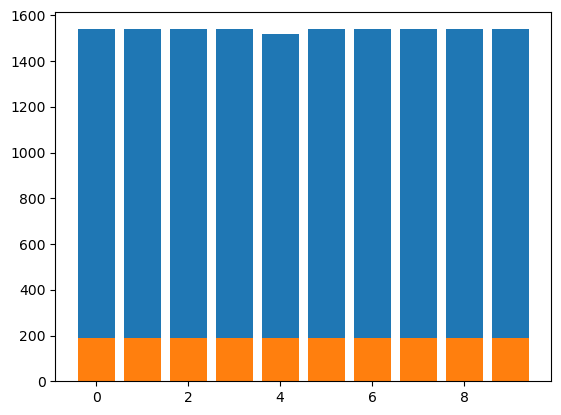

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Custom CNN (Melspectrogram version)

In [11]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

def conv_block_pad(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

In [12]:
#CNN+LSTM model
def create_model(input_shape, num_genres):

    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block_pad(x, 64)
    x = conv_block_pad(x, 128)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Reshape((16,64))(x)
    x = LSTM(units=128, dropout=0.1, return_sequences=True, input_shape=(8,128))(x)
    x = LSTM(units=128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(units=64, dropout=0.1, return_sequences=False)(x)
    
    x = Dense(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.02), activation='relu')(x)
 
    predictions = Dense(num_genres, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)

    model = Model(inputs=inpt, outputs=predictions)
    return model

In [13]:
model = create_model(X_train[0].shape, len(genres))

In [14]:
#stacked shape
X_train[0].shape

(128, 129, 3)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 127, 16)      448       
                                                                 
 activation (Activation)     (None, 126, 127, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 32)        4640      
                                                             

### Loss function

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [18]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_valid, y_valid), shuffle=False, callbacks=[reduceLROnPlat])

Epoch 1/150
121/121 [==============================] - 19s 54ms/step - loss: 2.9896 - accuracy: 0.1446 - val_loss: 2.6522 - val_accuracy: 0.1626 - lr: 0.0010
Epoch 2/150
121/121 [==============================] - 4s 36ms/step - loss: 2.4028 - accuracy: 0.1997 - val_loss: 2.1611 - val_accuracy: 0.2708 - lr: 0.0010
Epoch 3/150
121/121 [==============================] - 4s 36ms/step - loss: 2.1441 - accuracy: 0.2598 - val_loss: 2.0348 - val_accuracy: 0.2871 - lr: 0.0010
Epoch 4/150
121/121 [==============================] - 4s 35ms/step - loss: 2.0176 - accuracy: 0.2806 - val_loss: 1.8912 - val_accuracy: 0.3246 - lr: 0.0010
Epoch 5/150
121/121 [==============================] - 4s 34ms/step - loss: 1.9389 - accuracy: 0.2979 - val_loss: 1.8264 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 6/150
121/121 [==============================] - 4s 34ms/step - loss: 1.8738 - accuracy: 0.3136 - val_loss: 1.7860 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 7/150
121/121 [==============================] - 4s

Epoch 94/150
121/121 [==============================] - 4s 35ms/step - loss: 0.7100 - accuracy: 0.8646 - val_loss: 1.1182 - val_accuracy: 0.7281 - lr: 6.3025e-04
Epoch 95/150
121/121 [==============================] - 4s 34ms/step - loss: 0.7029 - accuracy: 0.8647 - val_loss: 1.1315 - val_accuracy: 0.7187 - lr: 6.3025e-04
Epoch 96/150
121/121 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.8627
Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0005987368611386045.
121/121 [==============================] - 4s 34ms/step - loss: 0.7034 - accuracy: 0.8627 - val_loss: 1.1363 - val_accuracy: 0.7158 - lr: 6.3025e-04
Epoch 97/150
121/121 [==============================] - 4s 34ms/step - loss: 0.6812 - accuracy: 0.8728 - val_loss: 1.1010 - val_accuracy: 0.7263 - lr: 5.9874e-04
Epoch 98/150
121/121 [==============================] - 4s 34ms/step - loss: 0.6778 - accuracy: 0.8740 - val_loss: 1.1018 - val_accuracy: 0.7310 - lr: 5.9874e-04
Epoch 99/150
121/121 [======

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.000 and val_acc = 0.769


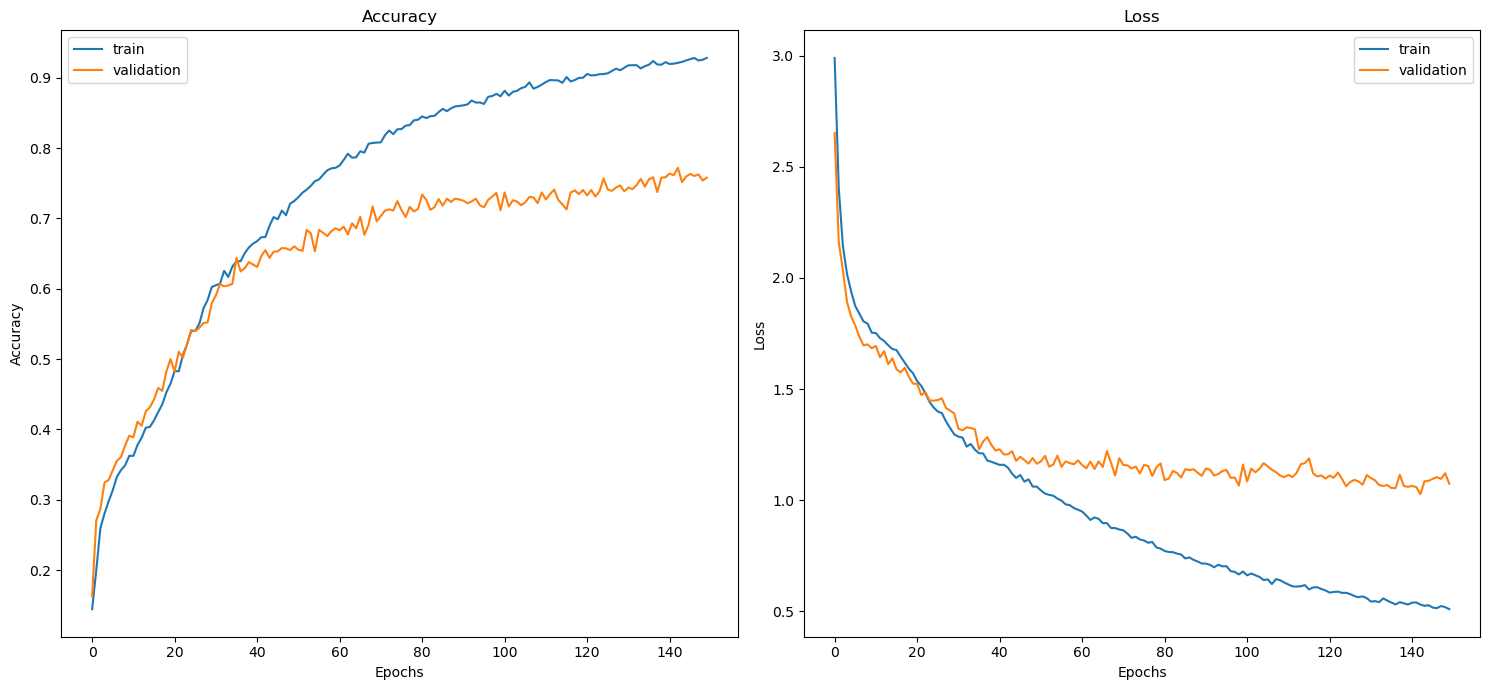

In [20]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

60/60 [==============================] - 2s 7ms/step


Normalized confusion matrix


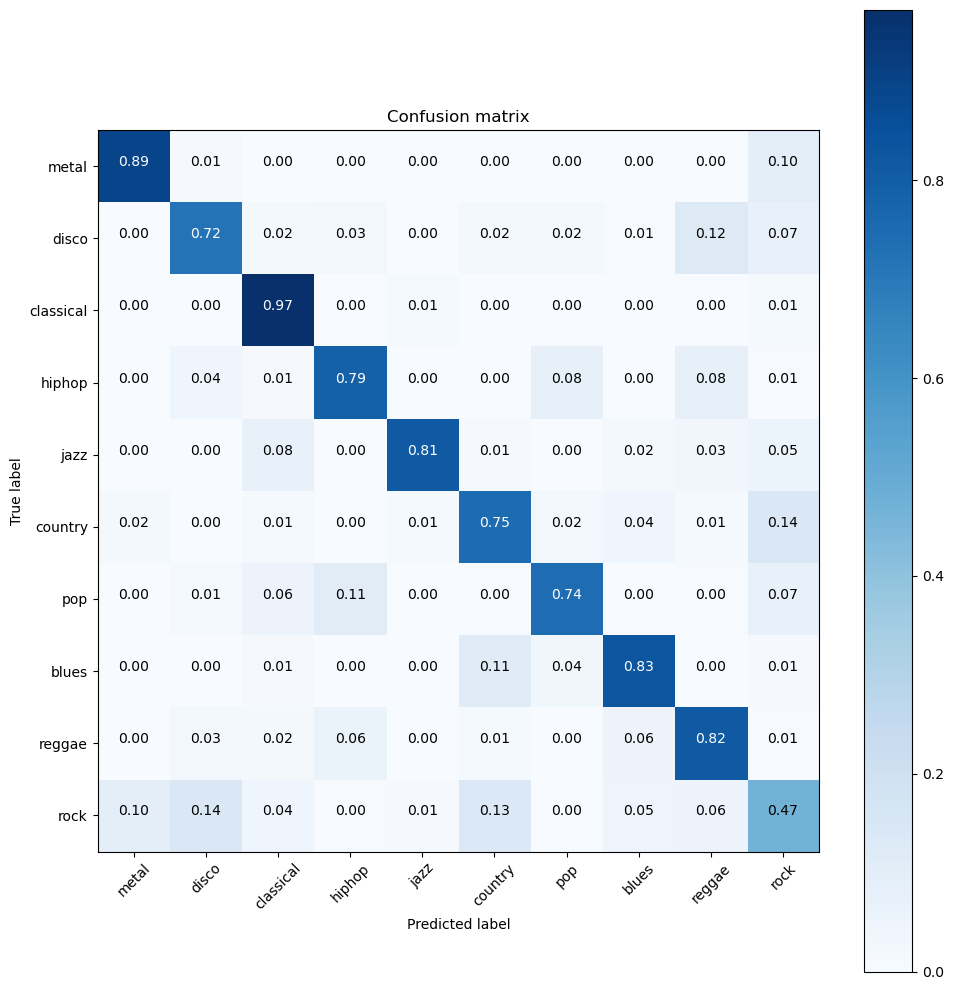

In [23]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [24]:
# Save the model
model.save('../models/custom_cnn_2d.h5')